# JNB1

TODO

<figure>
    <img src="assets/img/wf-JNB1.png" alt="JNB1 workflow">
    <figcaption><strong>Figure 1</strong>: Protocol workflow and part covered by this Jupyter Notebook highlighted in red.<figcaption>
<figure> 

## Load libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from ase import Atoms, Atom
# from ase.io import write
from ase.visualize import view
from pymatgen.analysis.elasticity.strain import Strain
from pymatgen.core import Lattice, Molecule, Structure

# from ase.visualize.plot import plot_atoms
# from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor

from tools import make_dir
from tools.mp import get_crystals, load_cifs

# import scipy as sci
# import glob




matget2ase = AseAtomsAdaptor()
plt.style.use("default")

## Settings

In [4]:
from tools.misc import MAIN_DIR

CHEM_FORMULA = "LiF"
SEED = 2718

Makeìing the output folder

In [5]:
make_dir(os.path.join(MAIN_DIR, CHEM_FORMULA))

## Get *Material Project* structures

In [6]:
SUBDIR = "0-materialproject"
MP_CIF_DIR = os.path.join(MAIN_DIR, CHEM_FORMULA, SUBDIR)
make_dir(MP_CIF_DIR)

Load possible structure from Material Project

In [7]:
info_df, systems, systems_ase = get_crystals("LiF")

N=3 crsital units found for the chemical formula `LiF`


In [8]:
info_df

energy_per_atom  formation_energy_per_atom
mp-1138           -4.845146                  -3.180409
mp-1185301        -4.838474                  -3.173737
mp-1009009        -4.557603                  -2.892867

Store the retrieved system and info

In [9]:
file_name = []
for i, (system, Ef_) in enumerate(zip(systems, info_df["formation_energy_per_atom"])):
    file_name.append(f"{i:d}-{CHEM_FORMULA}_{system.get_space_group_info()[0]}_{Ef_:1.2f}.cif".replace("/", ""))
    system.to(fmt="cif", filename=os.path.join(MP_CIF_DIR, file_name[-1]))

In addition we store the info as `json` file

In [10]:
info_df.loc[:, "file_name"] = file_name
info_df.set_index("file_name", inplace=True)
info_df.to_json(os.path.join(MP_CIF_DIR, "info.json"))

info_df

energy_per_atom  formation_energy_per_atom
file_name                                                         
0-LiF_Fm-3m_-3.18.cif         -4.845146                  -3.180409
1-LiF_P6_3mc_-3.17.cif        -4.838474                  -3.173737
2-LiF_Pm-3m_-2.89.cif         -4.557603                  -2.892867

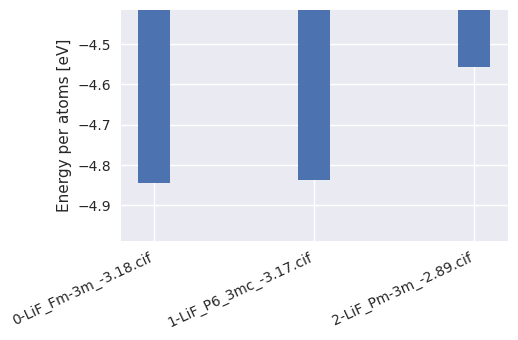

In [11]:
fig = plt.figure(figsize=[5, 3], dpi=100, facecolor="w")

with plt.style.context("seaborn"):
    ax = fig.add_subplot(111)
    Ef_np = info_df.energy_per_atom.values
    ax.bar(info_df.index.values, info_df.energy_per_atom.values, width=0.20)
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks([i for i in range(len(info_df.index))])
    ax.set_xticklabels(info_df.index.values, rotation=25, ha="right")
    delta_Ef = Ef_np.max() - Ef_np.min()
    mean_Ef = (Ef_np.max() + Ef_np.min()) / 2
    ax.set_ylim(mean_Ef - delta_Ef, mean_Ef + delta_Ef)
plt.show()

3D view of the system

In [12]:
view(systems_ase, viewer="ngl")

## Pure Species system

When modifying a system by adding or removing atoms for the purpose of ReaxFF training, it is beneficial to compare it with a stable system. For instance, instead of relying on the absolute energy of a Li atom added to a 2x2x2 supercell, it is more effective to use the energy difference relative to a stable crystal:

$\Delta E = E(Li_9F_8) - ( 8\times E(LiF) + 0.5 E(Li_2) )$

Therefore, in this section of the Jupyter Notebook, we will query the Materials Project database to obtain stable unit crystals that consist of only a single element.

In [13]:
SUBDIR = "0.1-pure_species"

Load structure

In [14]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Get unique elements in the system

In [15]:
elements = np.unique([i.name for i in systems[0][1].species])

Load possible structure from Material Project

In [16]:
info_df = []
systems = []
systems_ase = []

for el in elements:
    info_df_, systems_, systems_ase_ = get_crystals(el)
    indx = np.where(info_df_["energy_per_atom"] == info_df_["energy_per_atom"].min())[0][0]
    systems.append(systems_[indx])
    systems_ase.append(systems_ase_[indx])
    info_df__ = info_df_[info_df_["energy_per_atom"] == info_df_["energy_per_atom"].min()]
    temp_ = pd.DataFrame(columns=["element", "N"], index=info_df__.index)
    temp_["element"] = el
    temp_["N"] = len(systems_ase_[indx])
    info_df__ = info_df__.join(temp_)
    info_df.append(info_df__)
info_df = pd.concat(info_df)

N=5 crsital units found for the chemical formula `F`
N=8 crsital units found for the chemical formula `Li`


In [17]:
info_df

energy_per_atom  formation_energy_per_atom element  N
mp-561203         -1.911456                        0.0       F  4
mp-1018134        -1.908923                        0.0      Li  3

Store it

In [18]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
file_name = []
for i, (system, el, nel) in enumerate(zip(systems, info_df["element"], info_df["N"])):
    file_name.append(f"{i:d}-{el}_{system.get_space_group_info()[0].replace('/','')}_na{nel:d}.cif")
    system.to(fmt="cif", filename=os.path.join(out_dir, file_name[-1]))

In addition we store the info as `json` file

In [19]:
info_df.loc[:, "file_name"] = file_name
info_df.set_index("file_name", inplace=True)
info_df.to_json(os.path.join(out_dir, "info.json"))

info_df

energy_per_atom  formation_energy_per_atom element  N
file_name                                                               
0-F_C2c_na4.cif          -1.911456                        0.0       F  4
1-Li_R-3m_na3.cif        -1.908923                        0.0      Li  3

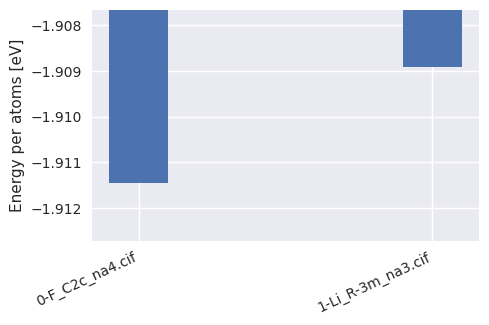

In [20]:
fig = plt.figure(figsize=[5, 3], dpi=100, facecolor="w")

with plt.style.context("seaborn"):
    ax = fig.add_subplot(111)
    Ef_np = info_df["energy_per_atom"].values
    ax.bar(file_name, Ef_np, width=0.20)
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks([i for i in range(len(Ef_np))])
    ax.set_xticklabels(file_name, rotation=25, ha="right")
    delta_Ef = Ef_np.max() - Ef_np.min()
    mean_Ef = (Ef_np.max() + Ef_np.min()) / 2
    ax.set_ylim(mean_Ef - delta_Ef, mean_Ef + delta_Ef)
plt.show()

In [21]:
view(systems_ase, viewer="ngl")

## Supercells 

In [29]:
SUBDIR = "1-supercell"
SUB_TRAINSET_ID = 1

Load structure

In [23]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [30]:
supercell_scale = [[2, 1, 1], [2, 2, 1], [2, 2, 2], [3, 2, 2], [3, 3, 2], [3, 3, 3]]
supercells = []
supercells_ase = []
supercell_info = {}

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell = syst_.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        supercells.append((filename, supercell.copy()))
        supercells_ase.append(matget2ase.get_atoms(supercell))
        # print(filename)
        n += 1

Store it

In [31]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, system in supercells:
    system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [32]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif                   2
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif                   4
1.2-0-LiF_Fm-3m_-3.18_2x2x2.cif                   8
1.3-0-LiF_Fm-3m_-3.18_3x2x2.cif                  12
1.4-0-LiF_Fm-3m_-3.18_3x3x2.cif                  18

In [33]:
v = view(supercells_ase, viewer="ngl")

## Elastic strain

In [35]:
SUBDIR = "2-strain"
SUB_TRAINSET_ID = 2

Load structure

In [38]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [40]:
supercell_scale = [(2, 2, 2)]
strain_amount = np.linspace(-0.125, 0.235, 13)
# defining the Green-Lagrange strain matrix
# in voigt notation [σ_xx, σ_yy, σ_zz, σ_yz, σ_xz, σ_xy]
strains = {
    "xx": np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    "xy": np.array([[0.0, 0.7, 0.0], [0.7, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    "xxyyzz": np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
}
new_systems = []
new_systems_ase = []
strain_info = {}

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale_x, scale_y, scale_z in supercell_scale:
        supercell = syst_.copy()
        supercell.make_supercell([scale_x, scale_y, scale_z])
        volume = supercell.volume
        for strain_type, strain_mtx in strains.items():
            for amount in strain_amount:
                filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{strain_type}_{amount:1.3f}.cif"
                obj_strain = Strain(strain_mtx * amount)
                strain_info[filename] = strain_mtx * amount
                defomation_mtx = obj_strain.get_deformation_matrix()
                obj_deformed = supercell.copy()
                obj_deformed = defomation_mtx.apply_to_structure(obj_deformed)
                new_systems.append((filename, obj_deformed.copy()))
                new_systems_ase.append(matget2ase.get_atoms(obj_deformed))
                n += 1

Store it

In [44]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)

for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [45]:
file_name = list(strain_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition", "strain_matrix"])
for file_name_ in file_name:
    info_df.loc[file_name_, "strain_matrix"] = strain_info[file_name_]
    info_df.loc[file_name_, "unitcell_repetition"] = np.prod(supercell_scale)
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                   8   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                   8   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                   8   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                   8   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                   8   

                                                                         strain_matrix  
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif  [[-0.125, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0...  
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif  [[-0.095, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0...  
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif  [[-0.065, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0...  
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif  [[-0.035, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0...  
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif  [[-0.0050000000000000044, -0.0, -0.0], [-0.0, ...

In [46]:
view(new_systems_ase, viewer="ngl")

### Vacancies 

In [10]:
SUB_TRAINSET_ID = 3

Load structure

In [11]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random remove a Atom in 2x2x2 supercell

In [12]:
from numpy.random import PCG64, Generator, RandomState
from pymatgen.analysis.defects.generators import VacancyGenerator

pcg64 = PCG64(seed=SEED)
rg = Generator(pcg64)

supercell_scale = [[2, 2, 1]]
max_vacacy = 5
vacancy_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        temporary = supercell.copy()
        prev_vacancy_el = []
        prev_vacancy_site = []
        for nv in range(max_vacacy):
            primitive_elements = [e.species_string for e in supercell.get_primitive_structure().sites]
            vacancy_gen = VacancyGenerator(temporary)
            temporary = []
            for v_site in list(vacancy_gen):
                site_el = v_site.site.species_string
                if site_el in primitive_elements:
                    primitive_elements.remove(site_el)
                elif len(primitive_elements) == 0:
                    break
                else:
                    continue
                filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_nv_{nv+1}.cif"
                vacancy_info["element"][filename] = prev_vacancy_el + [v_site.site.species_string]
                vacancy_info["site"][filename] = prev_vacancy_site + [v_site.site.coords]
                vacancy_info["unitcell_repetition"][filename] = np.prod(scale)
                obj_with_vacancy = v_site.generate_defect_structure().copy()
                new_systems.append((filename, obj_with_vacancy.copy()))
                new_systems_ase.append(matget2ase.get_atoms(obj_with_vacancy))
                n += 1
                temporary.append(obj_with_vacancy.copy())
            # Store some data
            Nidx = len(temporary)
            keys = list(vacancy_info["element"].keys())
            idx = rg.choice(Nidx)
            temporary = temporary[idx]
            key = keys[-Nidx:][idx]
            prev_vacancy_el = vacancy_info["element"][key]
            prev_vacancy_site = vacancy_info["site"][key]

Store it

In [13]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "3-vacancy")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

In [26]:
len(new_systems[0][1])

47

Save properties

In [14]:
file_name = list(vacancy_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["vacancy_site", "vacancy_element", "unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = vacancy_info["unitcell_repetition"][file_name_]
    info_df.loc[file_name_, "vacancy_site"] = vacancy_info["site"][file_name_]
    info_df.loc[file_name_, "vacancy_element"] = vacancy_info["element"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

vacancy_site  \
3.0-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif  [[-3.1698458656704757e-07, 2.6866683948763552,...   
3.1-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif                           [[0.0, 0.0, 1.34573275]]   
3.2-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif             [[3.350058001970321, 0.0, 4.03719825]]   
3.3-0-Li2CO3_P6_3mcm_-2.19_nv_2.cif  [[3.350058001970321, 0.0, 4.03719825], [-3.169...   
3.4-0-Li2CO3_P6_3mcm_-2.19_nv_2.cif  [[3.350058001970321, 0.0, 4.03719825], [-2.326...   

                                    vacancy_element unitcell_repetition  
3.0-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif            [Li]                   4  
3.1-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif             [C]                   4  
3.2-0-Li2CO3_P6_3mcm_-2.19_nv_1.cif             [O]                   4  
3.3-0-Li2CO3_P6_3mcm_-2.19_nv_2.cif         [O, Li]                   4  
3.4-0-Li2CO3_P6_3mcm_-2.19_nv_2.cif         [O, Li]                   4

In [77]:
v = view(new_systems_ase, viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase)
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

Plot

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



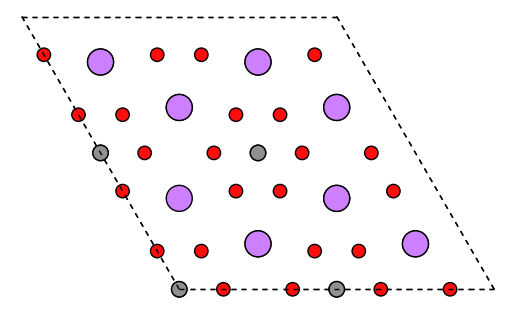

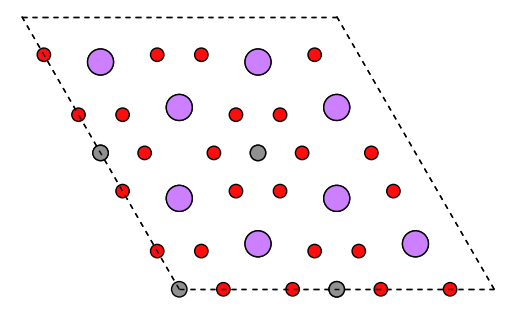

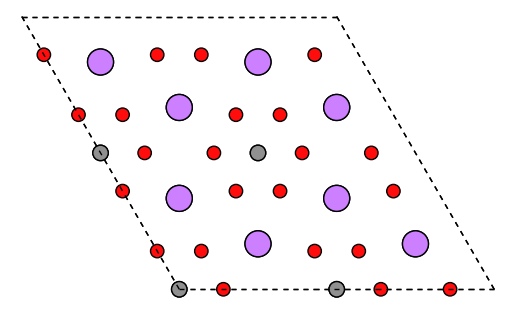

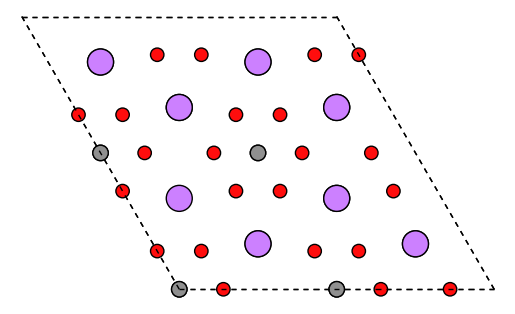

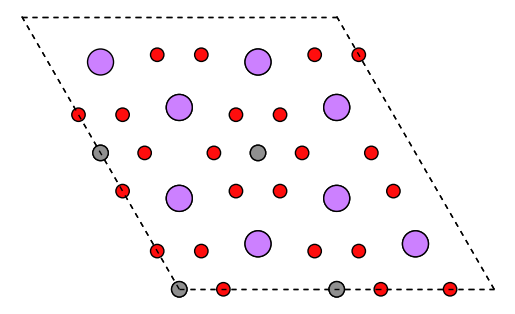

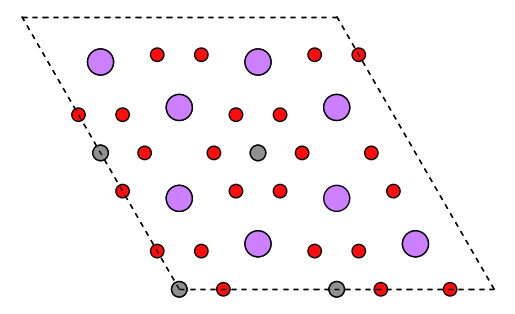

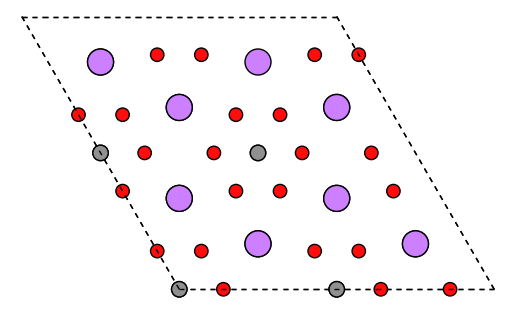

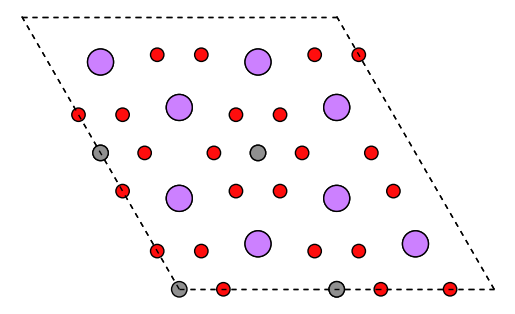

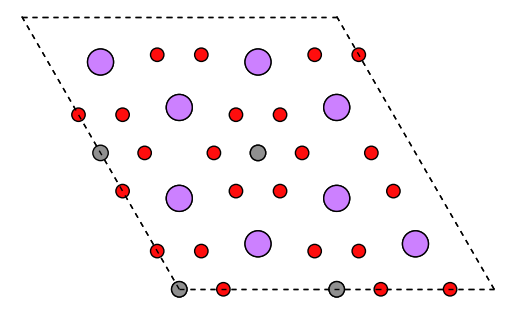

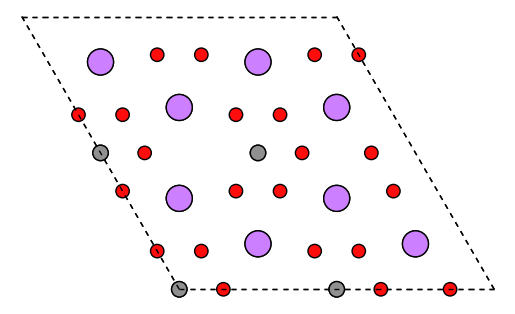

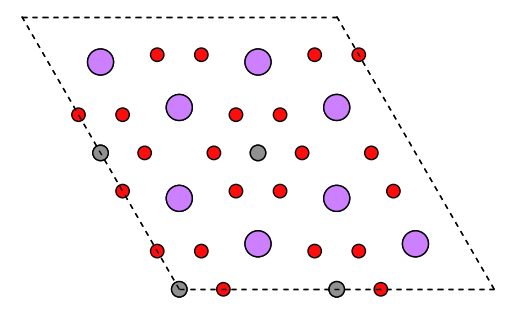

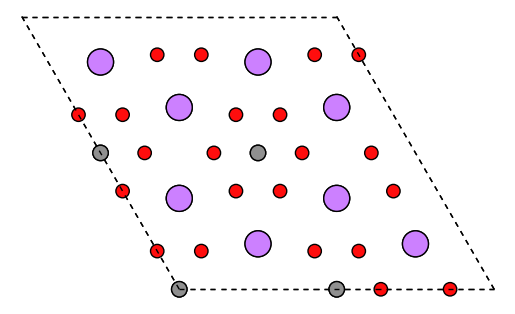

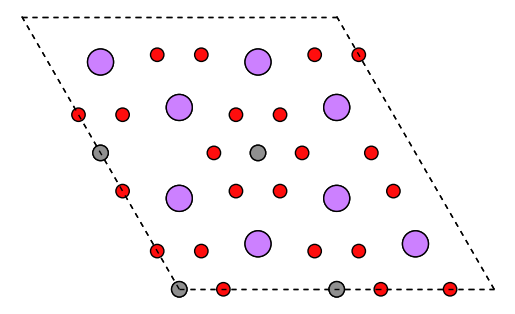

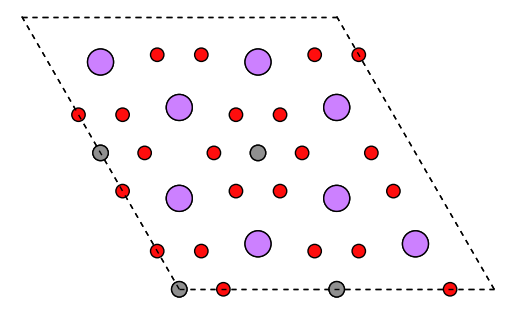

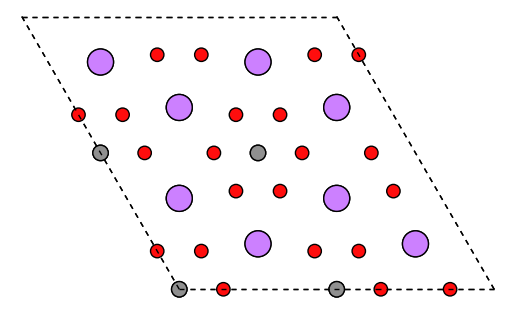

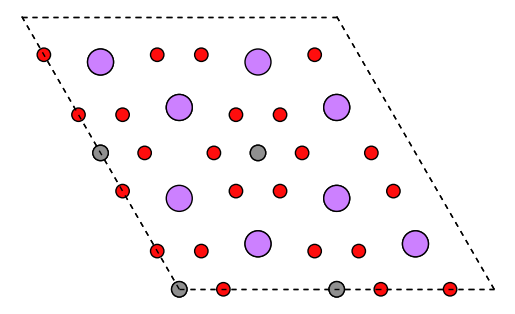

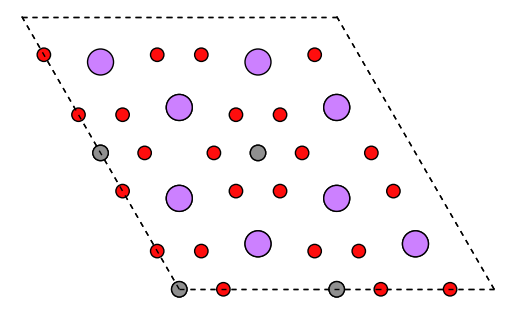

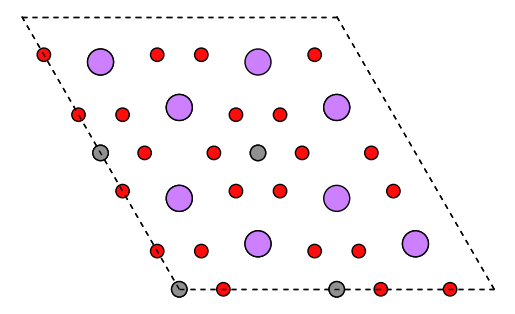

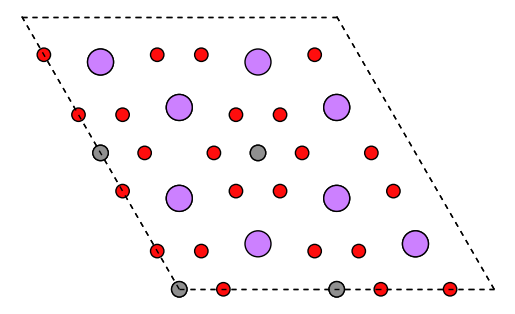

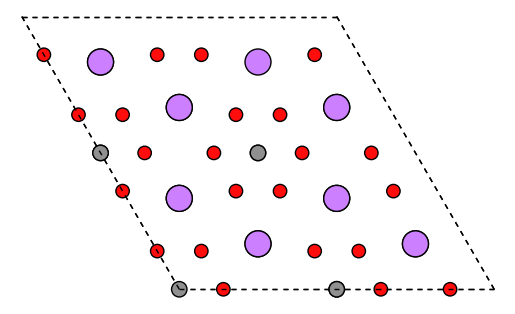

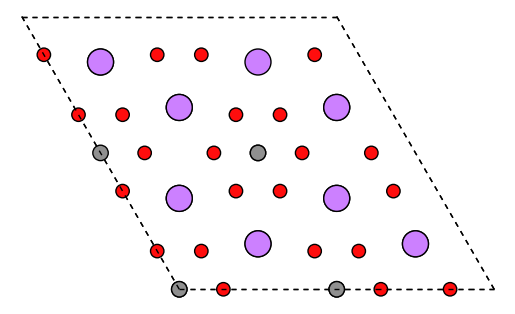

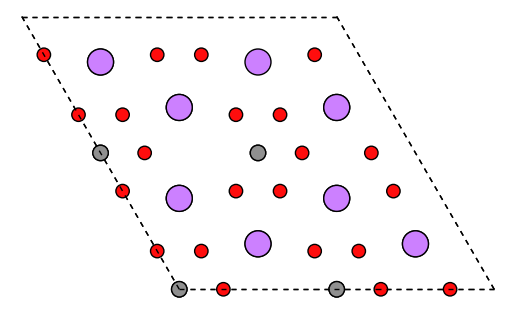

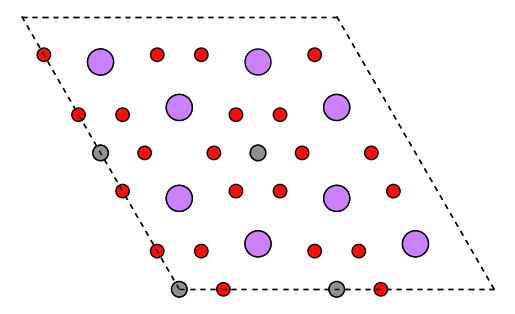

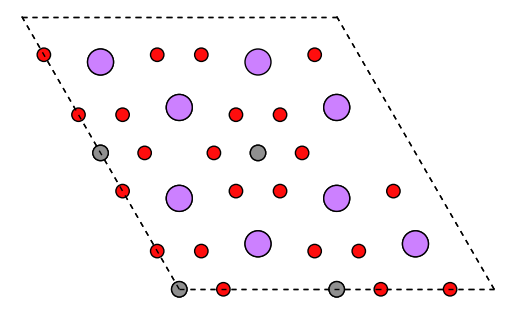

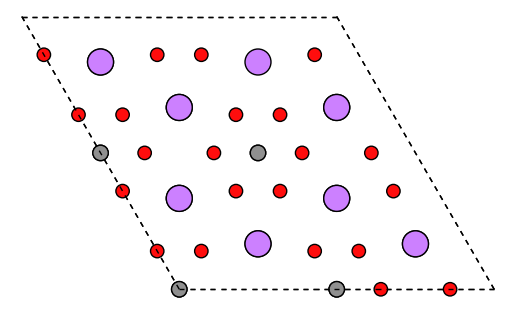

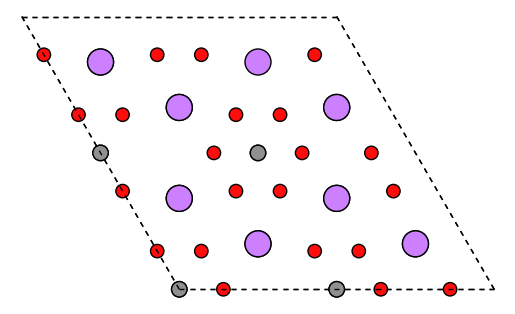

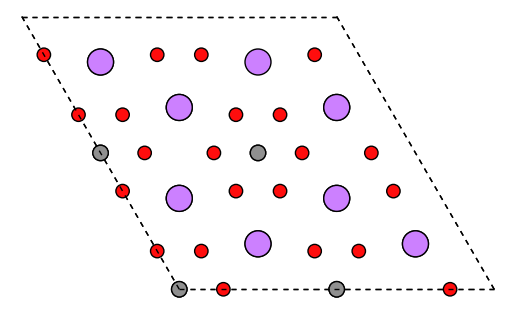

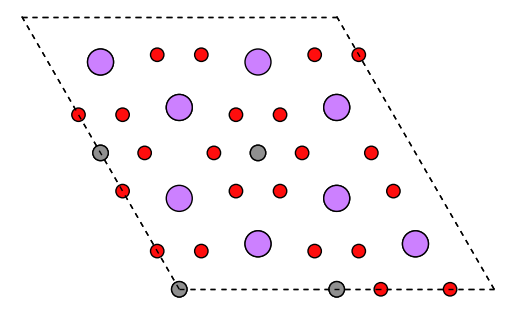

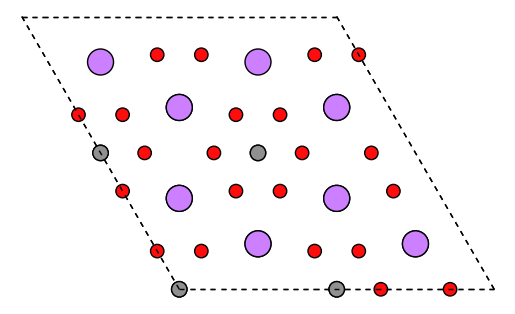

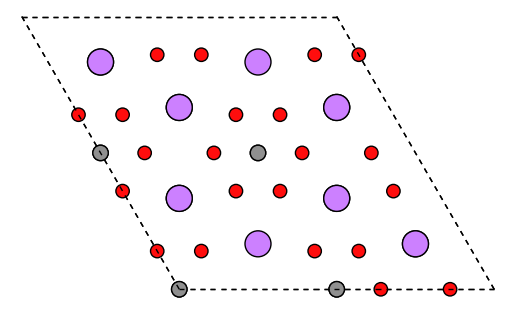

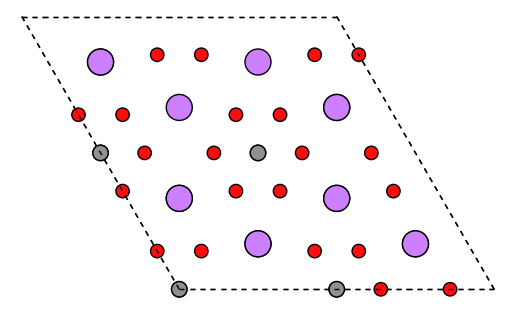

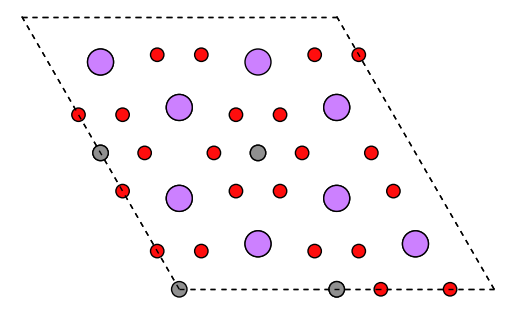

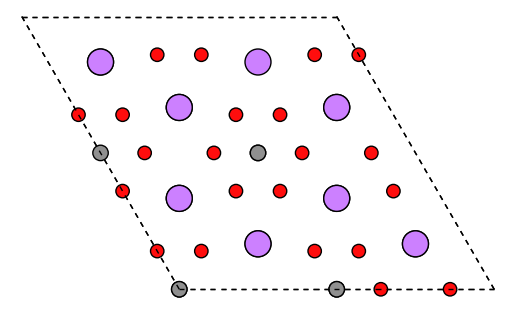

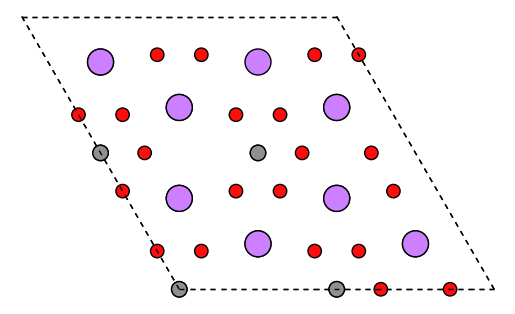

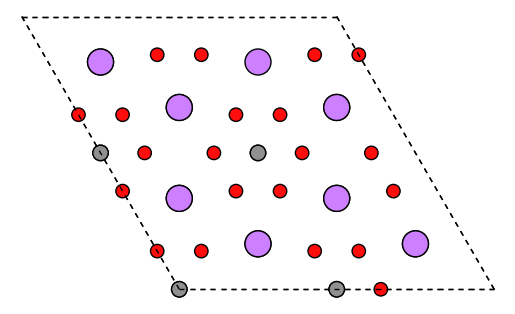

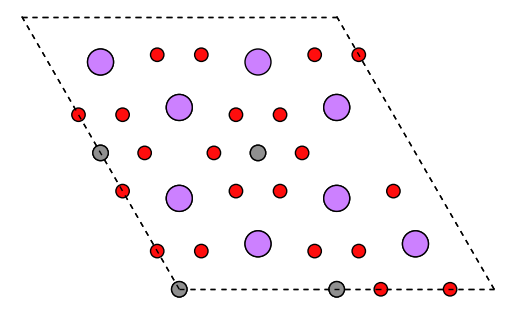

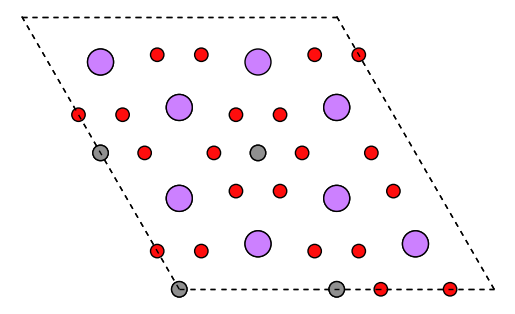

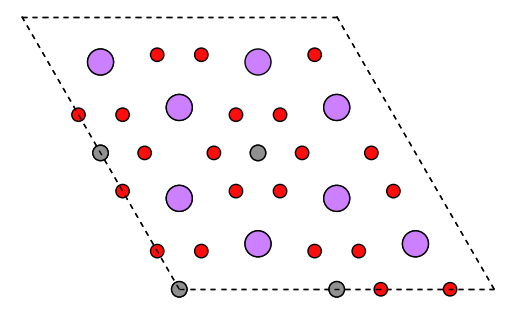

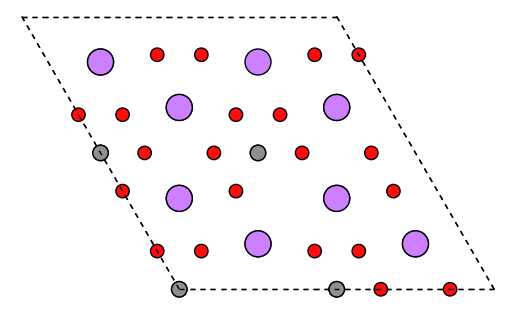

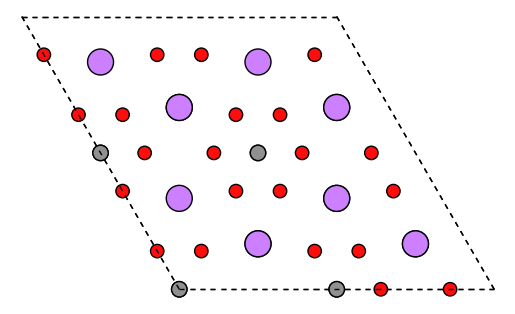

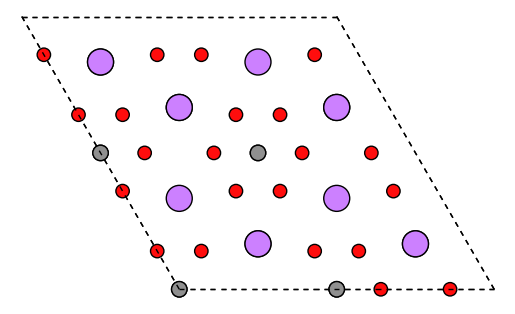

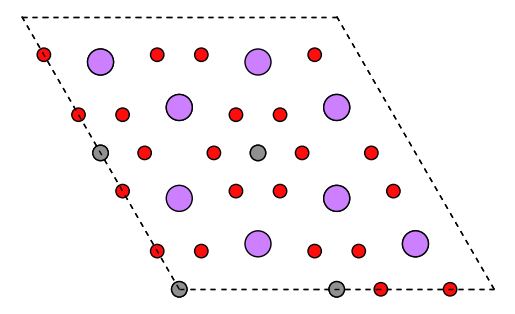

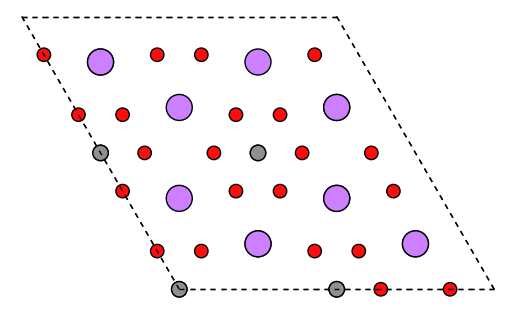

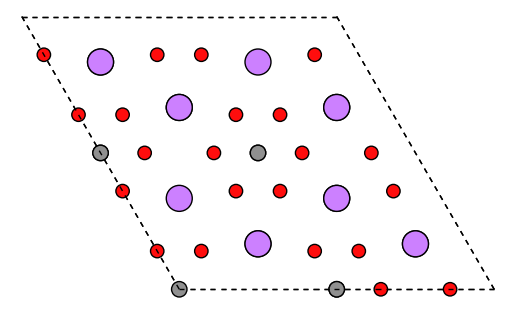

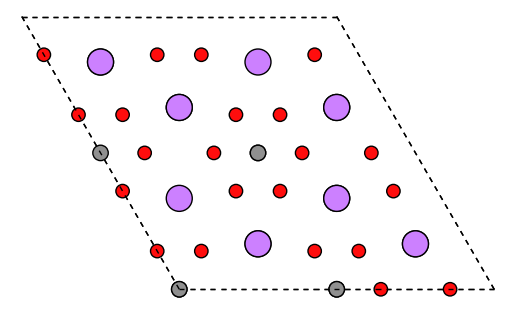

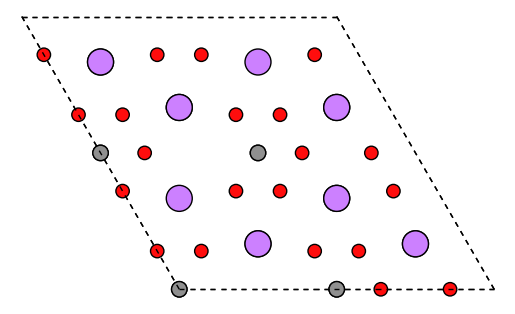

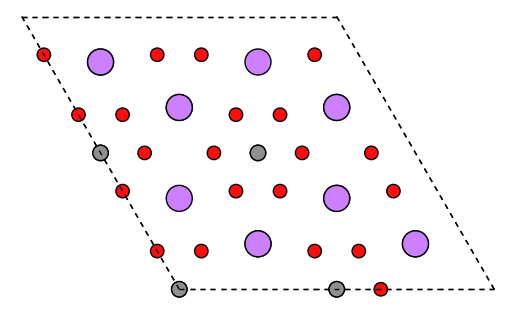

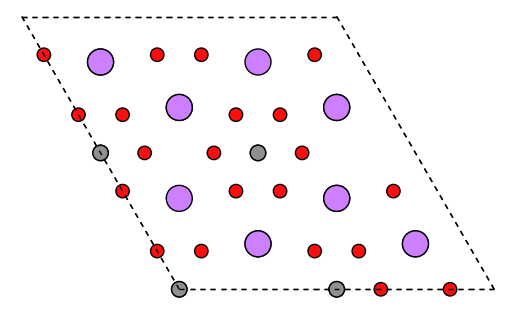

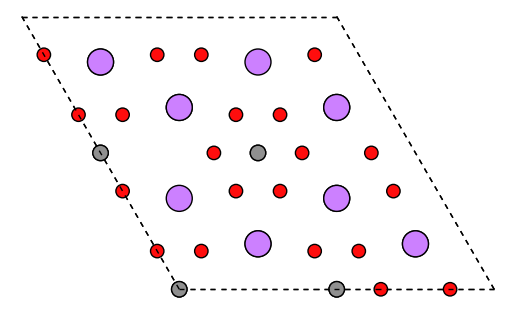

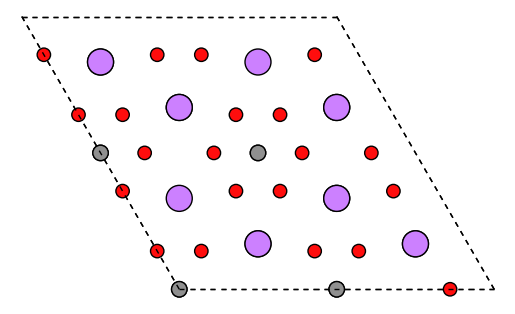

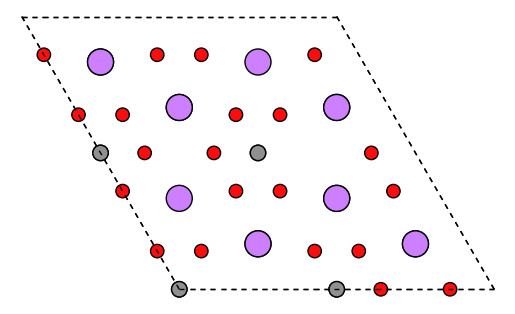

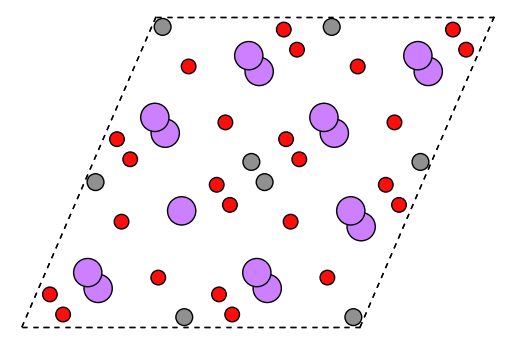

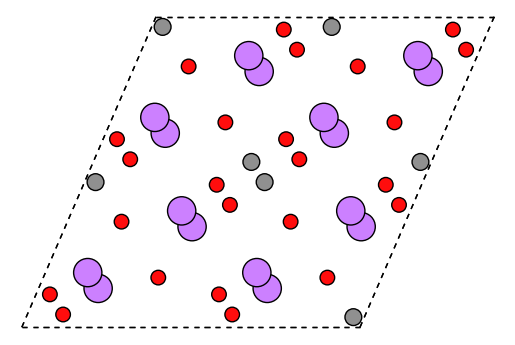

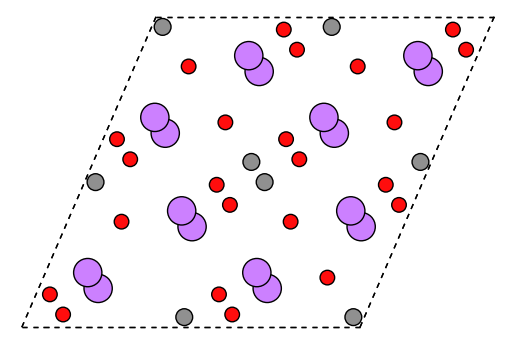

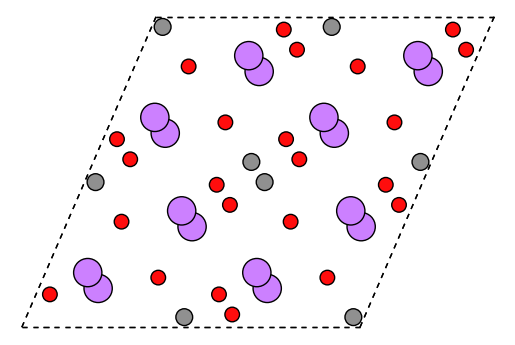

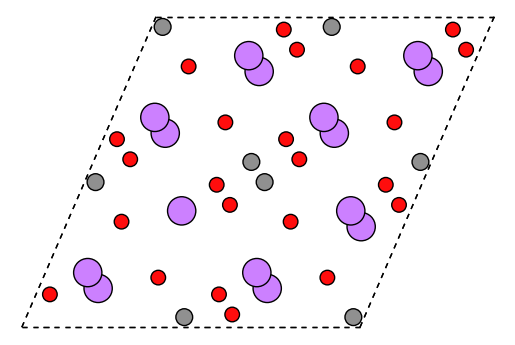

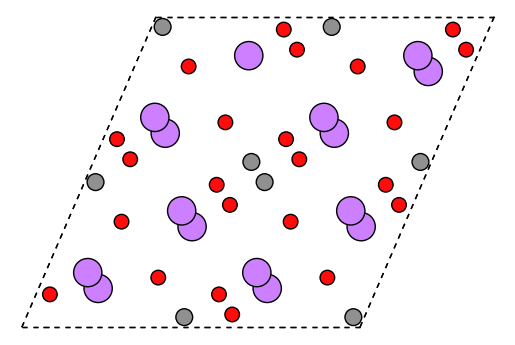

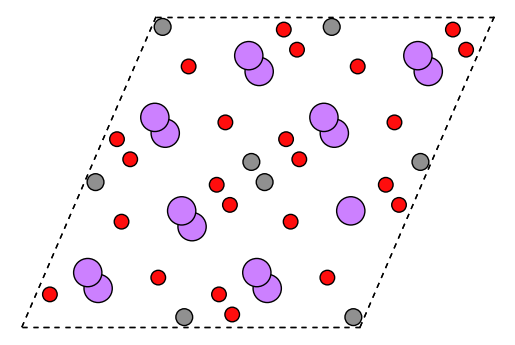

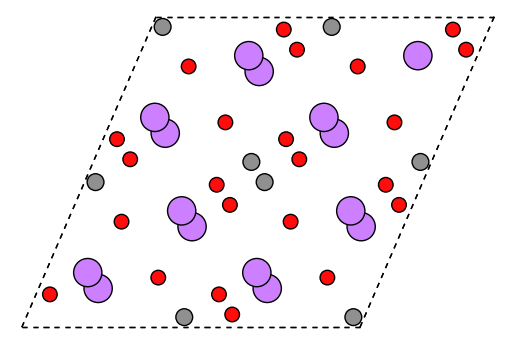

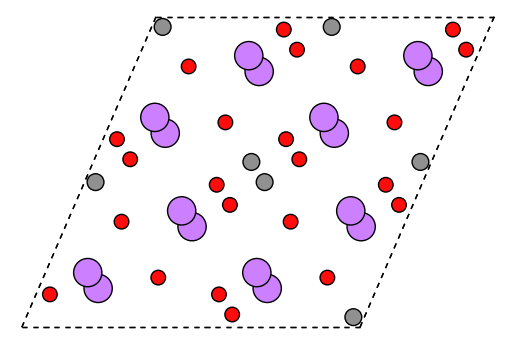

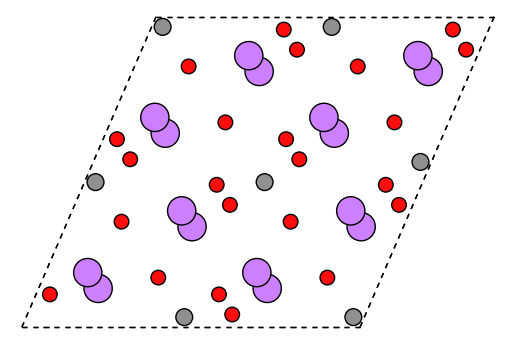

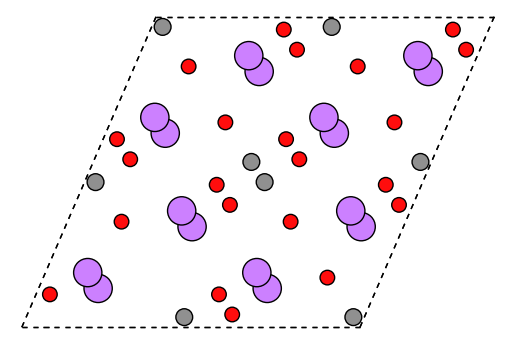

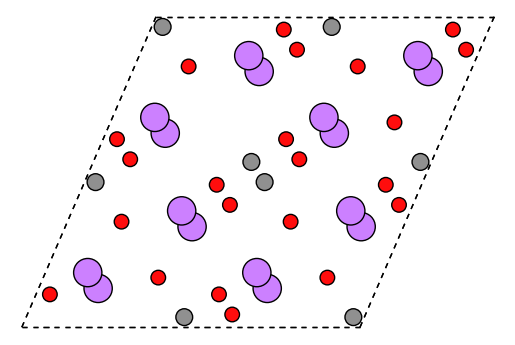

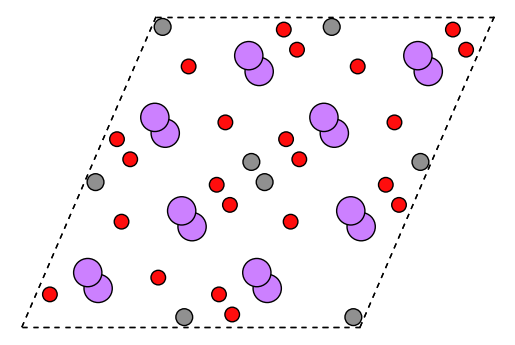

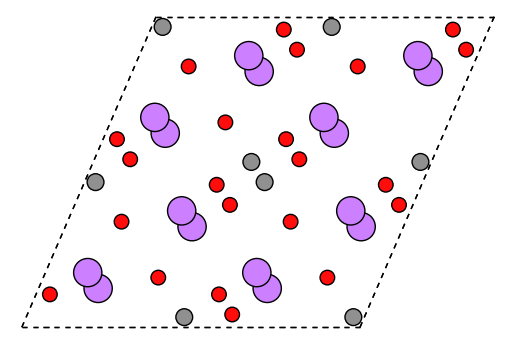

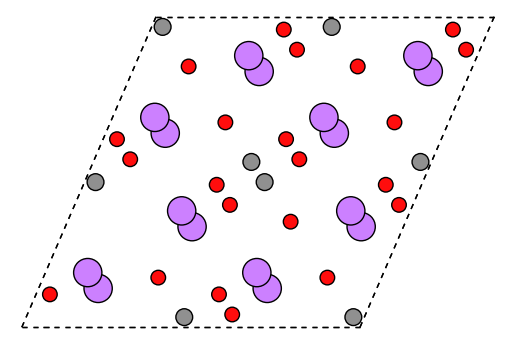

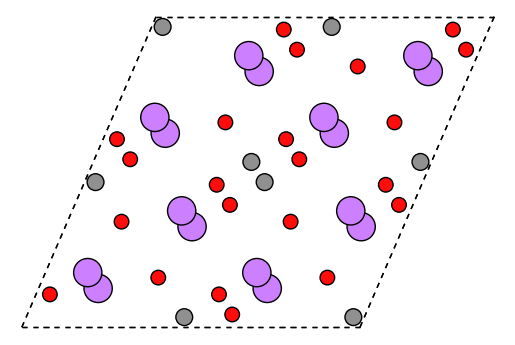

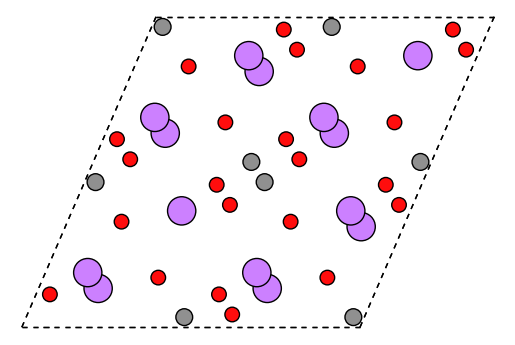

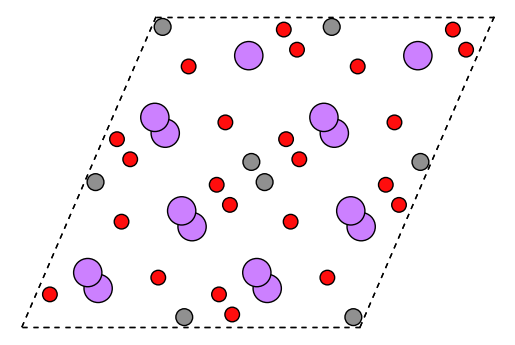

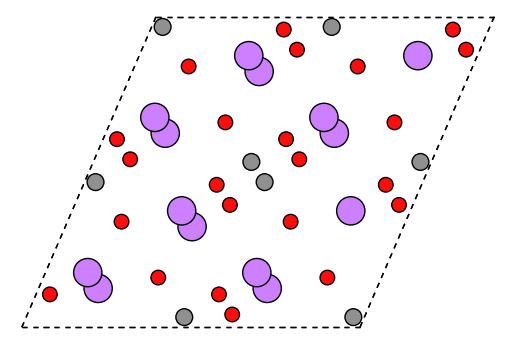

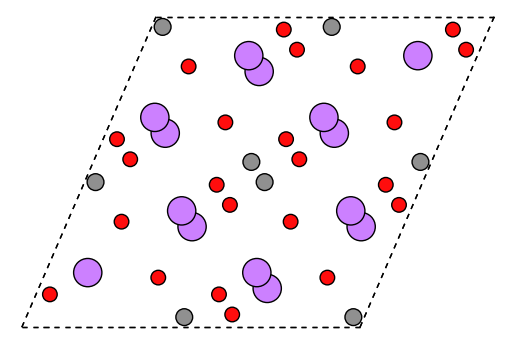

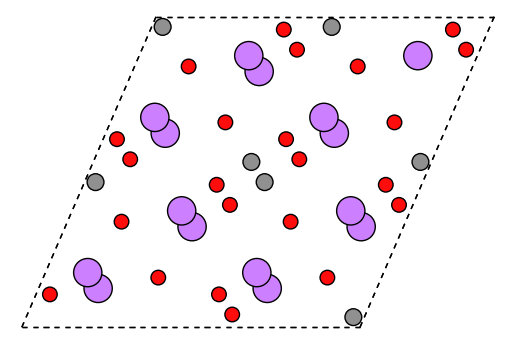

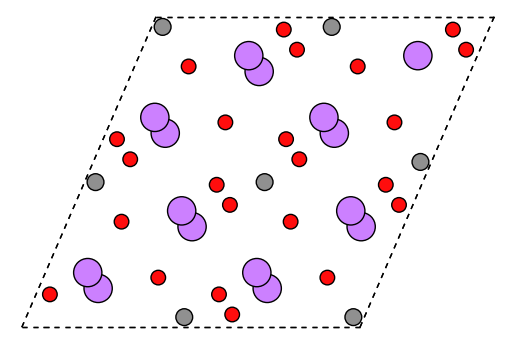

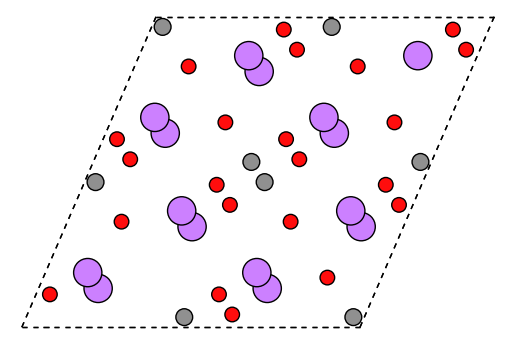

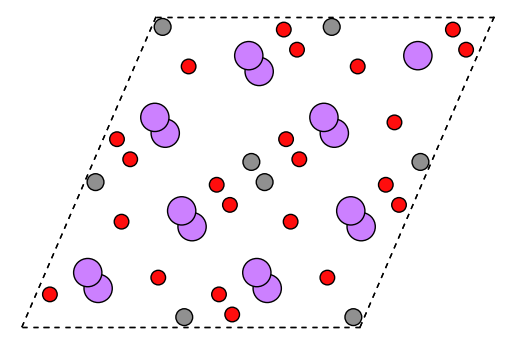

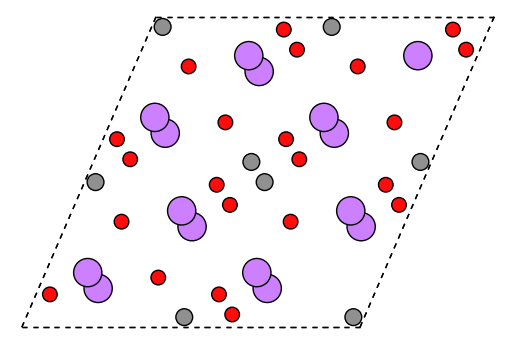

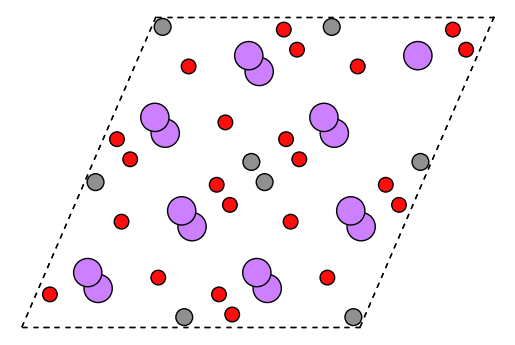

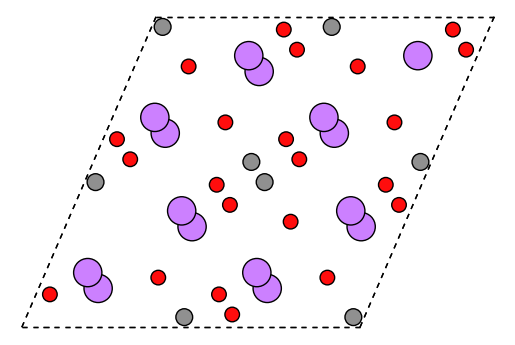

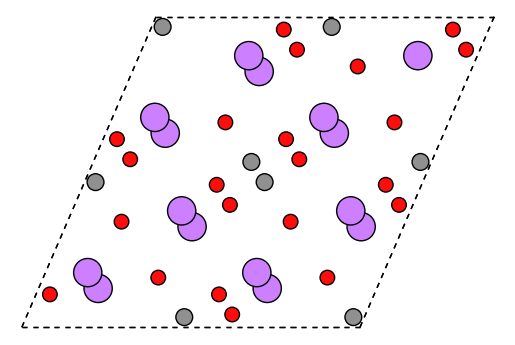

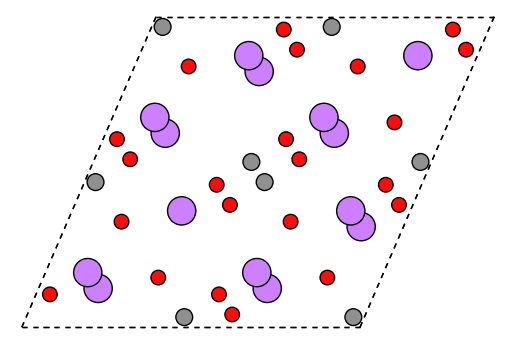

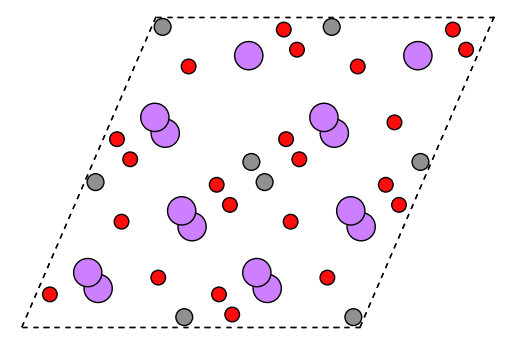

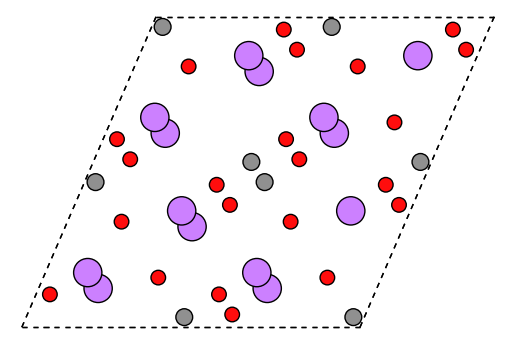

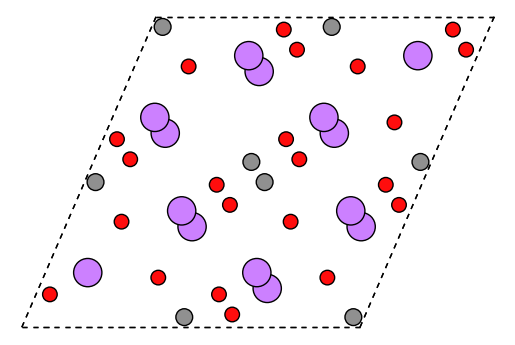

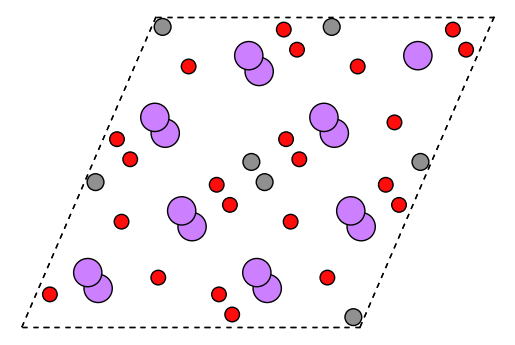

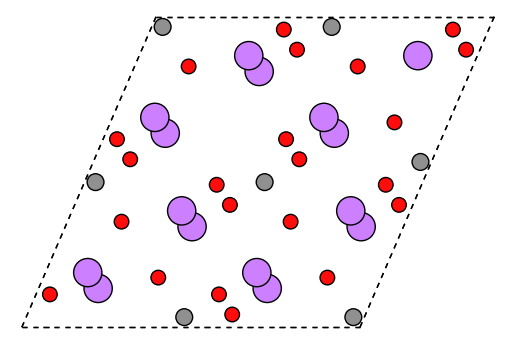

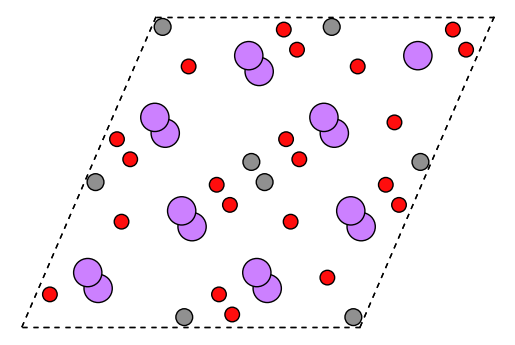

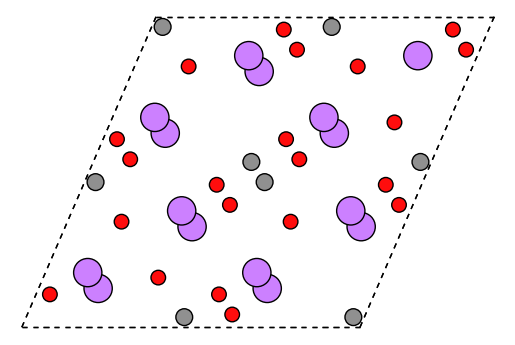

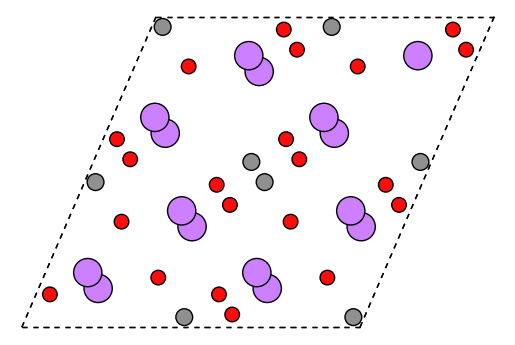

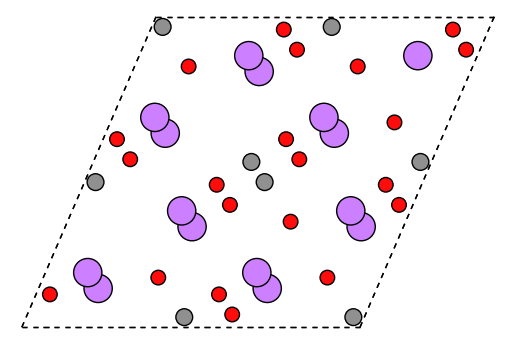

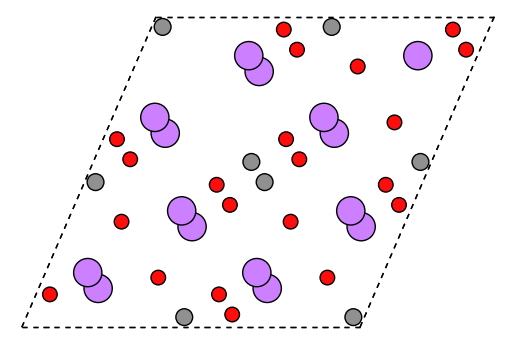

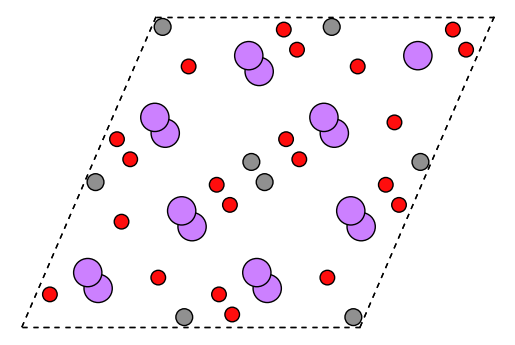

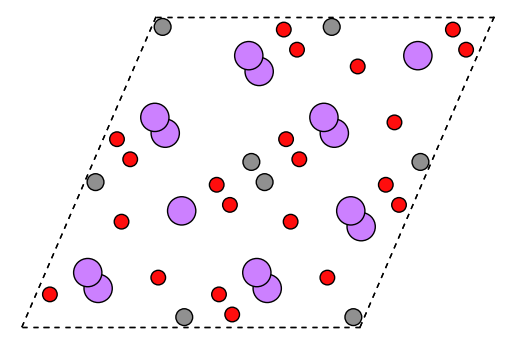

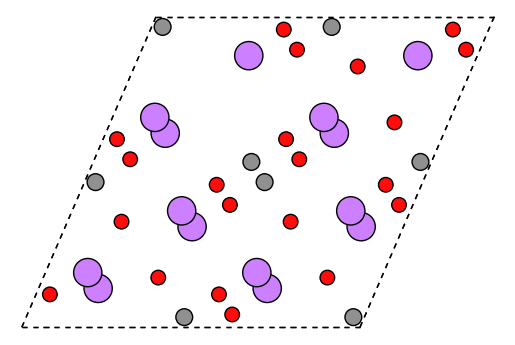

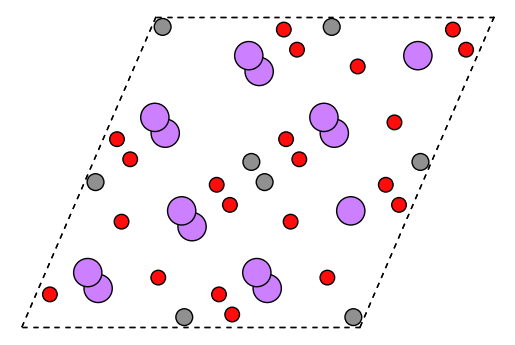

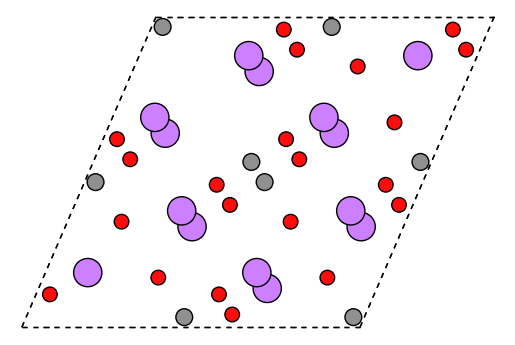

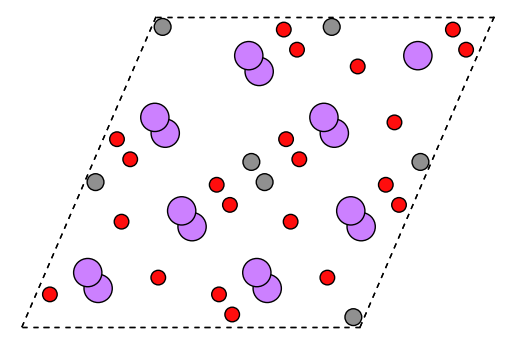

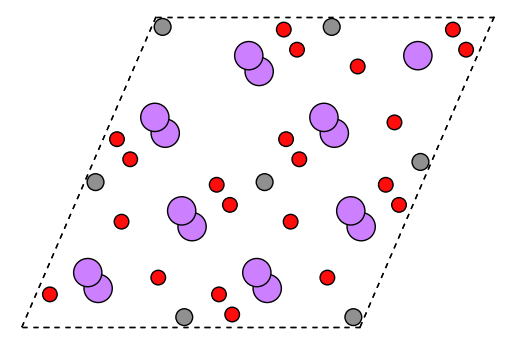

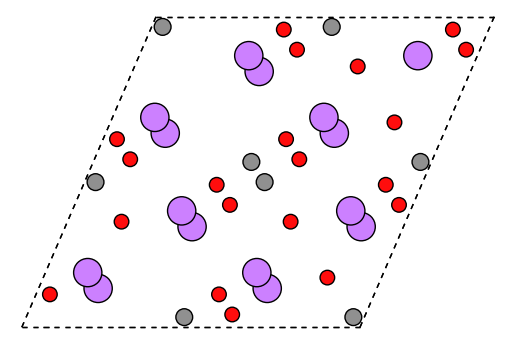

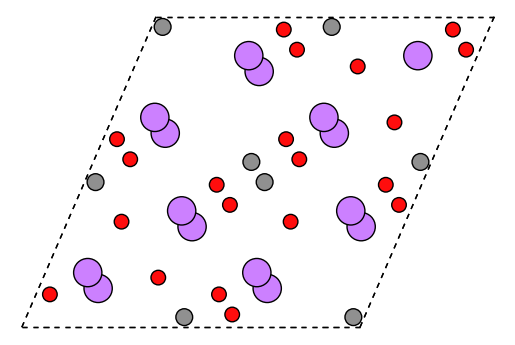

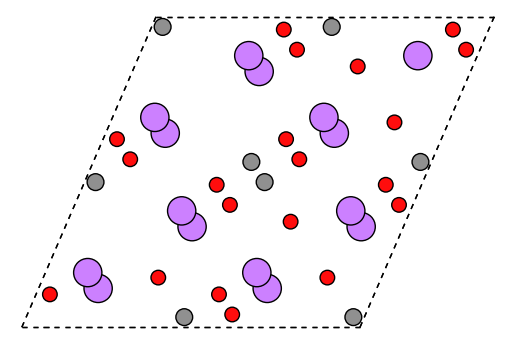

In [27]:
for name, sys in zip(file_name, new_systems_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".png"), dpi=200)

### Substitution 

In [5]:
SUB_TRAINSET_ID = 4

Load structure

In [6]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [11]:
from numpy.random import PCG64, Generator, RandomState
from pymatgen.analysis.defects.generators import SubstitutionGenerator

pcg64 = PCG64(seed=SEED)
rg = Generator(pcg64)

supercell_scale = [[2, 2, 1]]
max_substitution = 8
substitution_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        temporary = supercell.copy()
        prev_substitution_el = []
        prev_substitution_site = []
        for ns in range(max_substitution):
            substitution_gen = SubstitutionGenerator(temporary, "Li")
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_ns_{ns+1}.cif"
            sub_site = list(substitution_gen)
            n_sub_site = len(sub_site)
            idx = rg.choice(n_sub_site)
            sub_site = sub_site[idx]
            substitution_info["element"][filename] = prev_substitution_el + [sub_site.site.species_string]
            substitution_info["site"][filename] = prev_substitution_site + [sub_site.site.coords]
            substitution_info["unitcell_repetition"][filename] = np.prod(scale)
            obj_with_substitution = sub_site.generate_defect_structure().copy()
            new_systems.append((filename, obj_with_substitution.copy()))
            new_systems_ase.append(matget2ase.get_atoms(obj_with_substitution))
            prev_substitution_el = substitution_info["element"][filename]
            prev_substitution_site = substitution_info["site"][filename]
            temporary = obj_with_substitution.copy()
            n += 1

Store it

In [12]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "4-substitution")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [13]:
file_name = list(substitution_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["substitution_site", "substitution_element", "unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = substitution_info["unitcell_repetition"][file_name_]
    info_df.loc[file_name_, "substitution_site"] = substitution_info["site"][file_name_]
    info_df.loc[file_name_, "substitution_element"] = substitution_info["element"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

substitution_site  \
4.0-0-Li2CO3_P6_3mcm_-2.19_ns_1.cif            [[3.3500580019703214, 0.0, 4.03719825]]   
4.1-0-Li2CO3_P6_3mcm_-2.19_ns_2.cif  [[3.3500580019703214, 0.0, 4.03719825], [4.653...   
4.2-0-Li2CO3_P6_3mcm_-2.19_ns_3.cif  [[3.3500580019703214, 0.0, 4.03719825], [4.653...   
4.3-0-Li2CO3_P6_3mcm_-2.19_ns_4.cif  [[3.3500580019703214, 0.0, 4.03719825], [4.653...   
4.4-0-Li2CO3_P6_3mcm_-2.19_ns_5.cif  [[3.3500580019703214, 0.0, 4.03719825], [4.653...   

                                     substitution_element unitcell_repetition  
4.0-0-Li2CO3_P6_3mcm_-2.19_ns_1.cif                  [Li]                   4  
4.1-0-Li2CO3_P6_3mcm_-2.19_ns_2.cif              [Li, Li]                   4  
4.2-0-Li2CO3_P6_3mcm_-2.19_ns_3.cif          [Li, Li, Li]                   4  
4.3-0-Li2CO3_P6_3mcm_-2.19_ns_4.cif      [Li, Li, Li, Li]                   4  
4.4-0-Li2CO3_P6_3mcm_-2.19_ns_5.cif  [Li, Li, Li, Li, Li]                   4

In [14]:
v = view(new_systems_ase[4], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase)
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

Plot

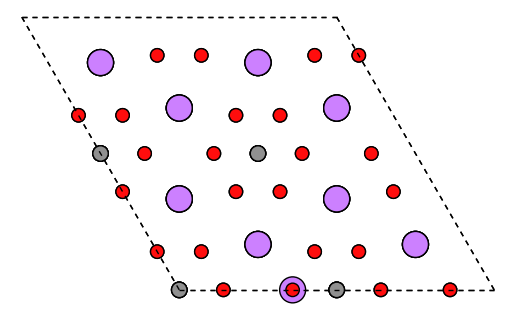

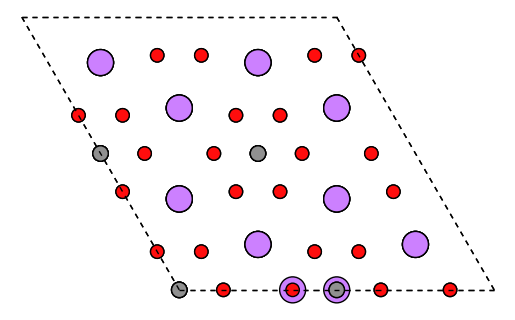

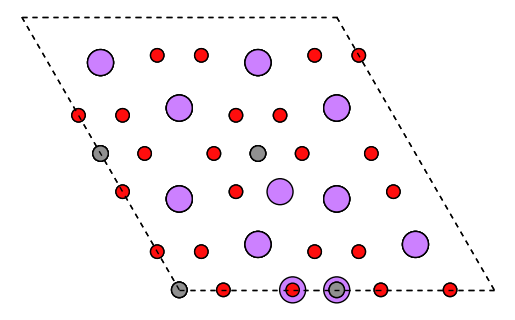

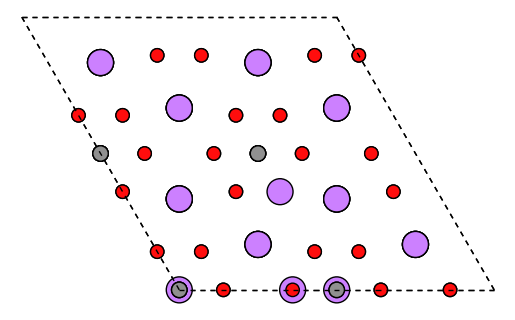

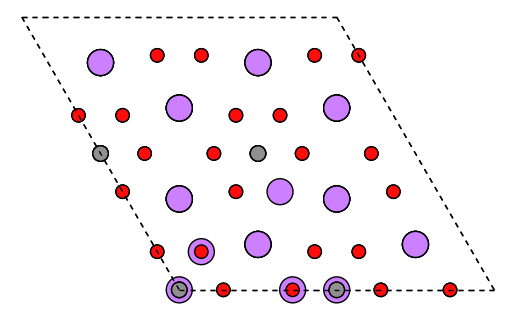

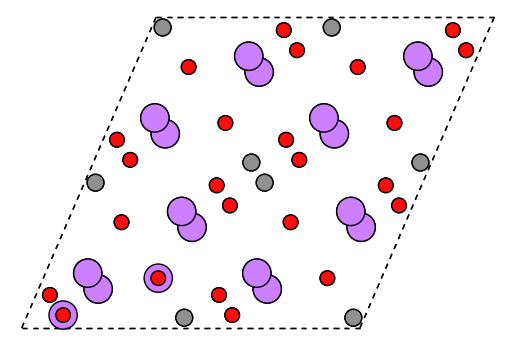

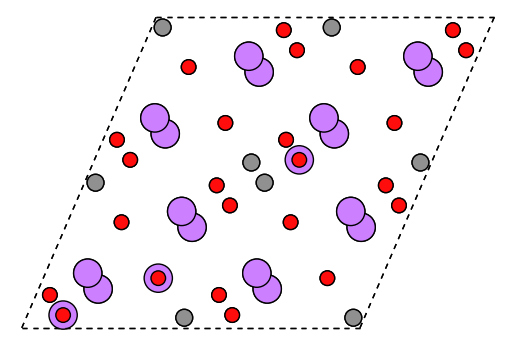

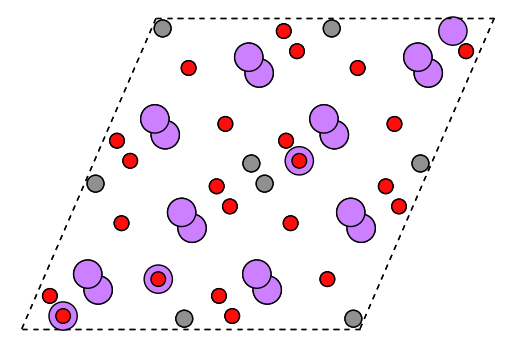

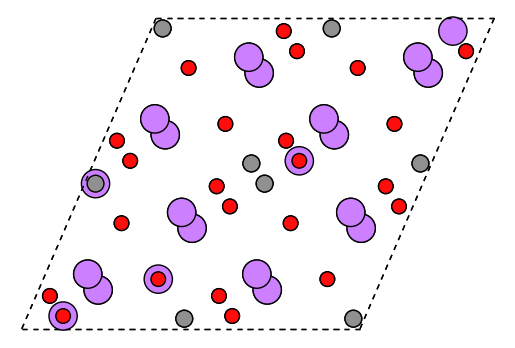

In [85]:
for name, sys in zip(file_name, new_systems_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".png"), dpi=200)

### Interstitial 

In [15]:
SUB_TRAINSET_ID = 5

Load structure

In [17]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [18]:
from numpy.random import PCG64, Generator, RandomState
from pymatgen.analysis.defects.generators import (
    InterstitialGenerator,
    VoronoiInterstitialGenerator,
)


def get_all_sites(sites, lattice, supercell=[1, 1, 1]):
    Na, Nb, Nc = supercell
    A, B, C = lattice.matrix
    sites_list = []

    for na in range(Na):
        for nb in range(Nb):
            for nc in range(Nc):
                for site in sites:
                    r_site = site.site.coords + A * na + B * nb + C * nc
                    sites_list.append(r_site)
    return sites_list

Random substitue a Atom in 2x2x2 supercell

In [19]:
pcg64 = PCG64(seed=SEED + SUB_TRAINSET_ID)
rg = Generator(pcg64)

supercell_scale = [[2, 2, 1]]
N_interstitial = np.arange(7)
interstitial_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        lattice = obj.lattice
        supercell = obj.copy()
        interstitial_gen = VoronoiInterstitialGenerator(obj, "Li")
        sites = list(interstitial_gen)
        r_sites = get_all_sites(sites, lattice, supercell=scale)
        rg.shuffle(r_sites, axis=0)
        supercell.make_supercell(scale)
        temporary = supercell.copy()
        prev_interstitial_el = []
        prev_interstitial_site = []
        for ni in N_interstitial:
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_ni_{ni}.cif"
            if ni == 0:
                interstitial_info["element"][filename] = []
                interstitial_info["site"][filename] = []
                interstitial_info["unitcell_repetition"][filename] = np.prod(scale)
            else:
                n_sites = len(r_sites)
                idx = rg.choice(n_sites)
                intestitial_r = r_sites.pop(idx)
                interstitial_info["element"][filename] = prev_interstitial_el + ["Li"]
                interstitial_info["site"][filename] = prev_interstitial_site + [intestitial_r]
                interstitial_info["unitcell_repetition"][filename] = np.prod(scale)
                temporary.append("Li", intestitial_r, coords_are_cartesian=True)
                temporary.set_charge(0.0)
            new_systems.append((filename, temporary.copy()))
            new_systems_ase.append(matget2ase.get_atoms(temporary))
            # print(filename)
            # print(intestitial_r, idx, len(new_systems_ase[-1]))
            prev_interstitial_el = interstitial_info["element"][filename]
            prev_interstitial_site = interstitial_info["site"][filename]
            n += 1

Store it

In [20]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "5-interstitial")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [21]:
file_name = list(interstitial_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition", "interstitial_site", "interstitial_element"])
for file_name_ in file_name:
    info_df.loc[file_name_, "interstitial_site"] = interstitial_info["site"][file_name_]
    info_df.loc[file_name_, "interstitial_element"] = interstitial_info["element"][file_name_]
    info_df.loc[file_name_, "unitcell_repetition"] = interstitial_info["unitcell_repetition"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition  \
5.0-0-Li2CO3_P6_3mcm_-2.19_ni_0.cif                   4   
5.1-0-Li2CO3_P6_3mcm_-2.19_ni_1.cif                   4   
5.2-0-Li2CO3_P6_3mcm_-2.19_ni_2.cif                   4   
5.3-0-Li2CO3_P6_3mcm_-2.19_ni_3.cif                   4   
5.4-0-Li2CO3_P6_3mcm_-2.19_ni_4.cif                   4   

                                                                     interstitial_site  \
5.0-0-Li2CO3_P6_3mcm_-2.19_ni_0.cif                                                 []   
5.1-0-Li2CO3_P6_3mcm_-2.19_ni_1.cif  [[5.30514071901484, 0.37625579306477325, 2.691...   
5.2-0-Li2CO3_P6_3mcm_-2.19_ni_2.cif  [[5.30514071901484, 0.37625579306477325, 2.691...   
5.3-0-Li2CO3_P6_3mcm_-2.19_ni_3.cif  [[5.30514071901484, 0.37625579306477325, 2.691...   
5.4-0-Li2CO3_P6_3mcm_-2.19_ni_4.cif  [[5.30514071901484, 0.37625579306477325, 2.691...   

                                    interstitial_element  
5.0-0-Li2CO3_P6_3mcm_-2.19_ni_0.cif                   []  
5.1-0-Li2CO3_P6_3mcm_-2.19_ni_1.cif                 [Li]  
5.2-0-Li2CO3_P6_3mcm_-2.19_ni_2.cif             [Li, Li]  
5.3-0-Li2CO3_P6_3mcm_-2.19_ni_3.cif         [Li, Li, Li]  
5.4-0-Li2CO3_P6_3mcm_-2.19_ni_4.cif     [Li, Li, Li, Li]

In [25]:
v = view(new_systems_ase[3], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

Plot

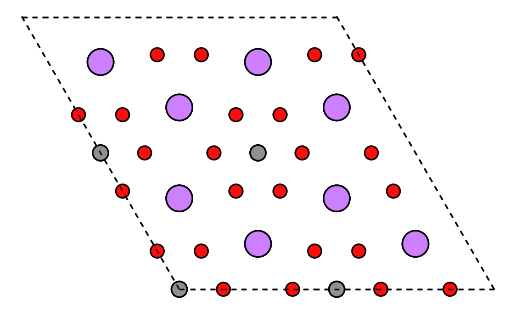

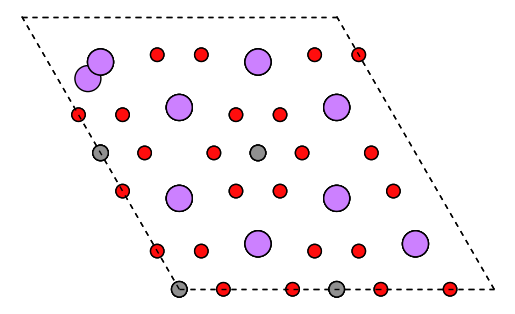

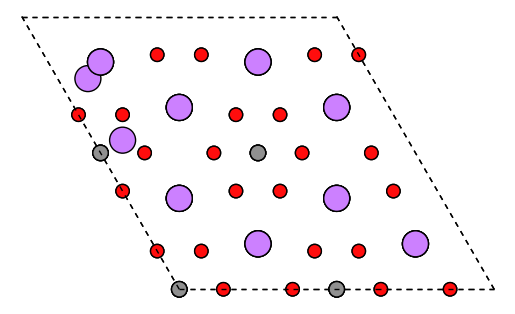

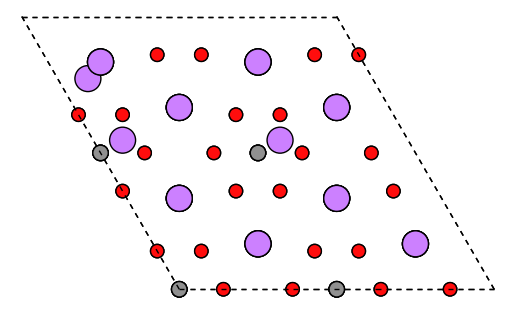

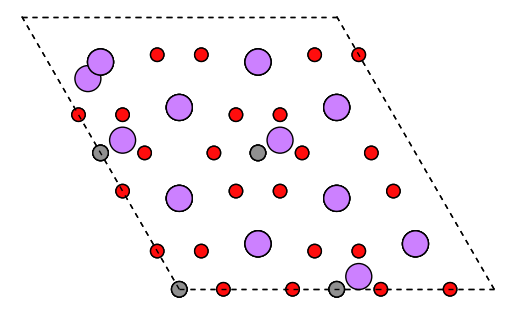

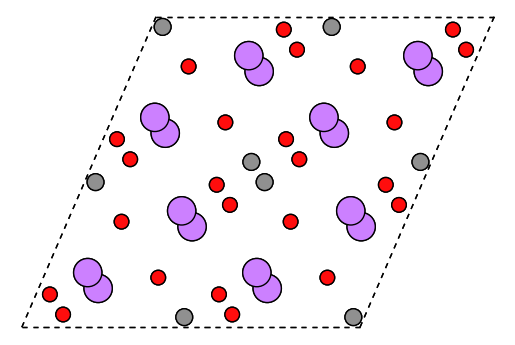

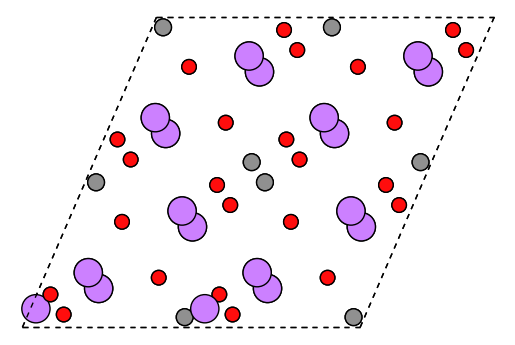

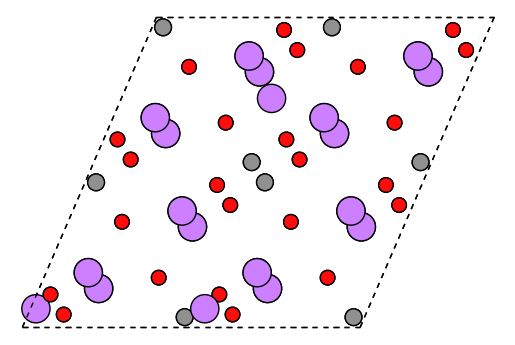

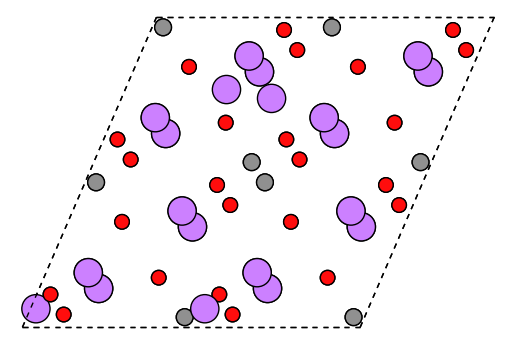

In [93]:
for name, sys in zip(file_name, new_systems_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".png"), dpi=200)

### Slabs 

In [4]:
SUB_TRAINSET_ID = 6

Load structure

In [5]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [6]:
for i in range(2):
    print(systems[i][1].lattice.parameters)

(4.65344648, 4.65344648, 5.382931, 90.0, 90.0, 120.00000676000002)
(4.90692313, 4.90692313, 6.34779188, 69.38285223, 69.38285223, 61.861750750000006)


Random substitue a Atom in 2x2x2 supercell

In [7]:
from pymatgen.core.surface import SlabGenerator

# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [1, 1, 1]
Nslabs = [1, 2, 3]
millers = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 1), (2, 1, 1)]
min_vacuum_size = 10  # [Ang]
slab_info = {"millers": {}, "slabs": {}}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for hkl in millers:
        for n_slabs in Nslabs:
            hkl_str = "".join([str(index) for index in hkl])
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{hkl_str}x{n_slabs}.cif"
            lc = obj.lattice.parameters[3]
            vacuum_size = max([int(np.ceil(min_vacuum_size / lc) + 1), 2])
            slabgen = SlabGenerator(
                obj,
                miller_index=hkl,
                min_slab_size=n_slabs,
                in_unit_planes=True,
                min_vacuum_size=vacuum_size,
                lll_reduce=False,
                center_slab=True,
            )
            slab = slabgen.get_slab()
            slab.make_supercell(supercell_scale)
            slab_info["millers"][filename] = hkl
            slab_info["slabs"][filename] = n_slabs
            new_systems.append((filename, slab.copy()))
            new_systems_ase.append(matget2ase.get_atoms(slab.copy()))
            n += 1

In [8]:
# for i, (name, sys) in enumerate(new_systems):
#     if sys.lattice.parameters[2] > sys.lattice.parameters[1]:
#         print( sys.lattice.parameters[2] > sys.lattice.parameters[1])
#     else:
#         print(i, sys.lattice.parameters)

Store it

In [9]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "6-slabs")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [10]:
file_name = list(slab_info["millers"].keys())
info_df = pd.DataFrame(index=file_name, columns=["millers", "slabs"])
for file_name_ in file_name:
    info_df.loc[file_name_, "millers"] = slab_info["millers"][file_name_]
    info_df.loc[file_name_, "slabs"] = slab_info["slabs"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

millers slabs
6.0-0-Li2CO3_P6_3mcm_-2.19_001x1.cif  (0, 0, 1)     1
6.1-0-Li2CO3_P6_3mcm_-2.19_001x2.cif  (0, 0, 1)     2
6.2-0-Li2CO3_P6_3mcm_-2.19_001x3.cif  (0, 0, 1)     3
6.3-0-Li2CO3_P6_3mcm_-2.19_010x1.cif  (0, 1, 0)     1
6.4-0-Li2CO3_P6_3mcm_-2.19_010x2.cif  (0, 1, 0)     2

In [15]:
len(info_df)

60

In [12]:
v = view(new_systems_ase, viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

Plot

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



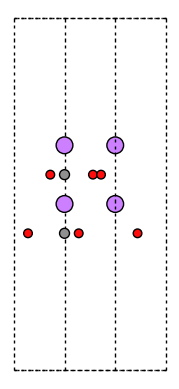

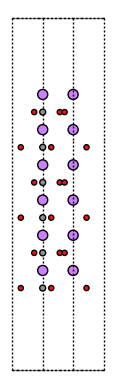

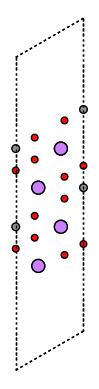

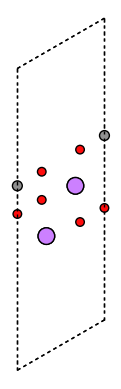

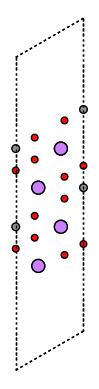

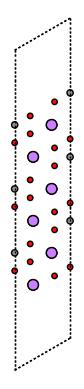

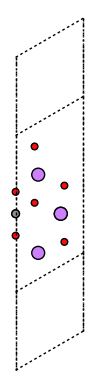

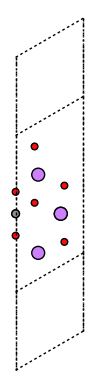

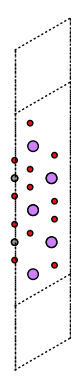

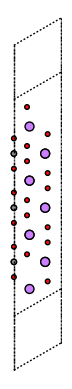

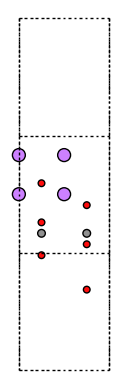

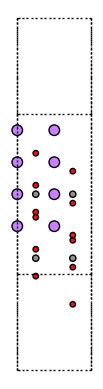

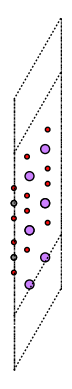

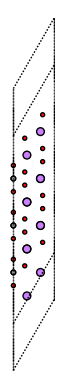

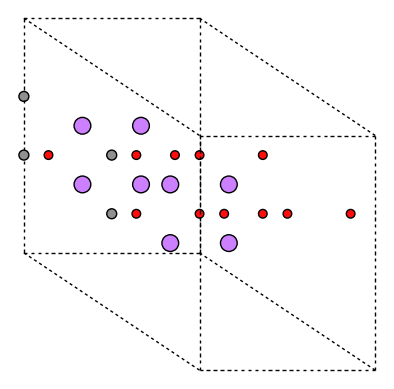

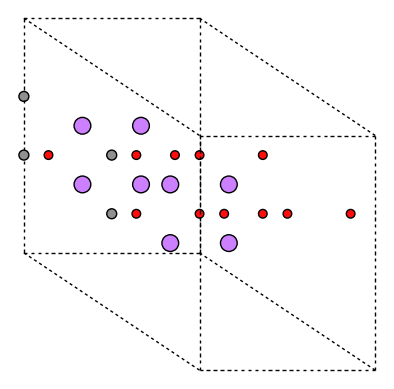

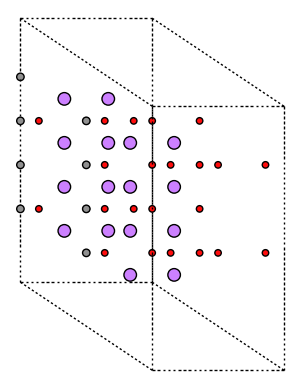

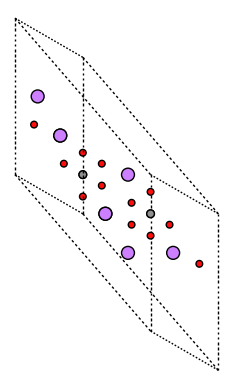

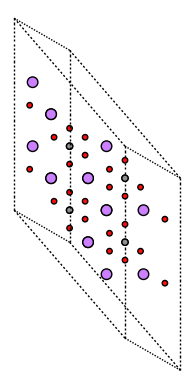

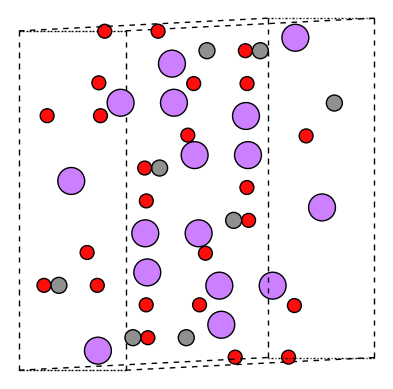

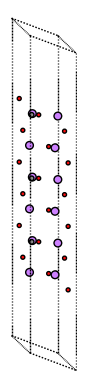

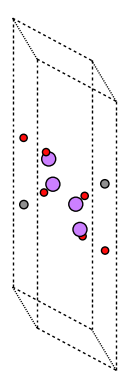

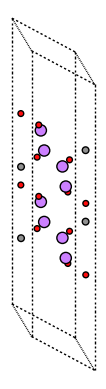

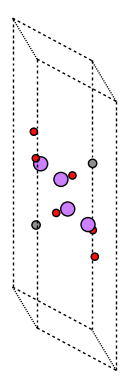

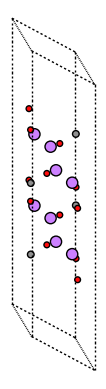

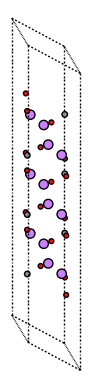

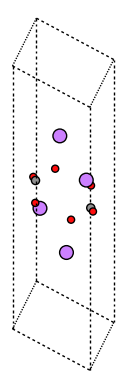

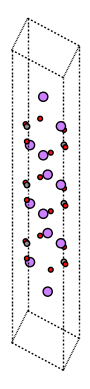

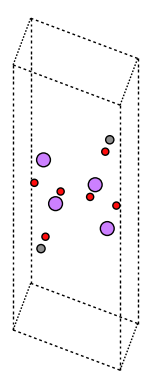

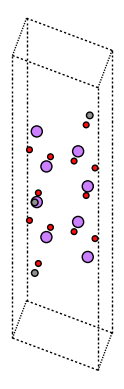

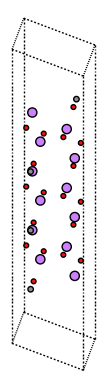

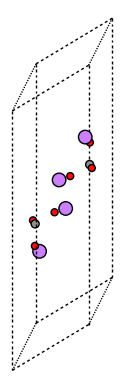

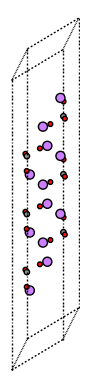

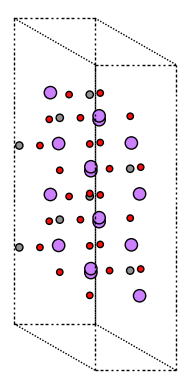

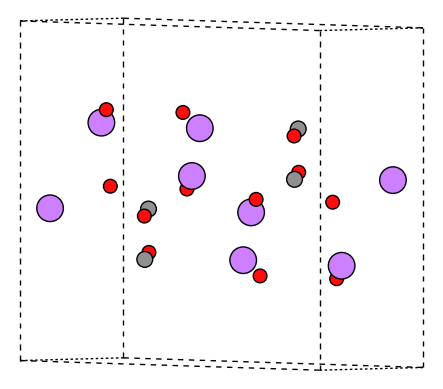

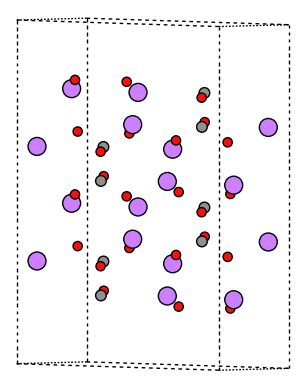

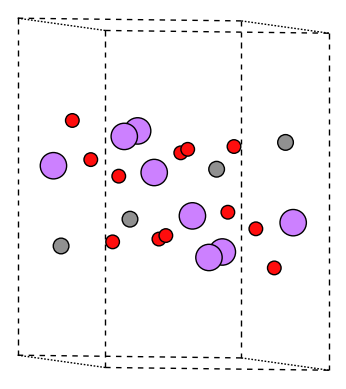

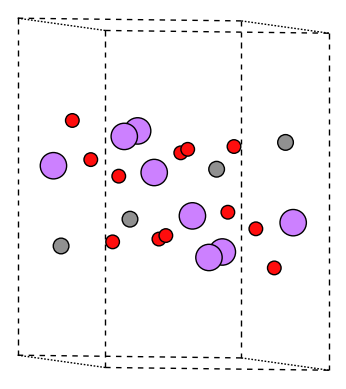

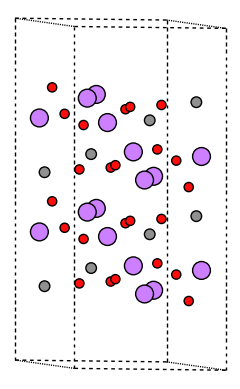

In [13]:
for name, sys in zip(file_name, new_systems_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("90x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".png"), dpi=200)

### Amorphous bulk  

In [5]:
SUB_TRAINSET_ID = 7

Load structure

In [6]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [7]:
# from pymatgen.core.surface import SlabGenerator
# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell(scale)
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

In [12]:
print(new_systems_ase)

[Atoms(symbols='C16Li32O48', pbc=True, cell=[[9.30689296, 0.0, 5.698828336735519e-16], [-4.653447430953761, 8.060005184629066, 5.698828336735519e-16], [0.0, 0.0, 10.765862]]), Atoms(symbols='C16Li32O48', pbc=True, cell=[[9.185310555272885, 0.0, 3.4556690261233833], [3.6448365632192874, 8.431197804833385, 3.4556690261233833], [0.0, 0.0, 12.69558376]])]


Store it

In [8]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "7-amorphous")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

In [13]:
new_system

Structure Summary
Lattice
    abc : 9.81384626 9.81384626 12.69558376
 angles : 69.38285223 69.38285223 61.861750750000006
 volume : 983.1862537912655
      A : 9.185310555272885 0.0 3.4556690261233833
      B : 3.6448365632192874 8.431197804833385 3.4556690261233833
      C : 0.0 0.0 12.69558376
PeriodicSite: Li (4.6242, 2.7315, 3.4373) [0.3749, 0.3240, 0.0805]
PeriodicSite: Li (4.6242, 2.7315, 9.7851) [0.3749, 0.3240, 0.5805]
PeriodicSite: Li (6.4466, 6.9471, 5.1651) [0.3749, 0.8240, 0.0805]
PeriodicSite: Li (6.4466, 6.9471, 11.5129) [0.3749, 0.8240, 0.5805]
PeriodicSite: Li (9.2169, 2.7315, 5.1651) [0.8749, 0.3240, 0.0805]
PeriodicSite: Li (9.2169, 2.7315, 11.5129) [0.8749, 0.3240, 0.5805]
PeriodicSite: Li (11.0393, 6.9471, 6.8929) [0.8749, 0.8240, 0.0805]
PeriodicSite: Li (11.0393, 6.9471, 13.2407) [0.8749, 0.8240, 0.5805]
PeriodicSite: Li (2.0729, 1.0549, 3.1923) [0.1760, 0.1251, 0.1695]
PeriodicSite: Li (2.0729, 1.0549, 9.5401) [0.1760, 0.1251, 0.6695]
PeriodicSite: Li (3.8953, 5

Save properties

In [10]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
7.0-0-Li2CO3_P6_3mcm_-2.19_2x2x2.cif                   8
7.0-1-Li2CO3_C2c_-2.26_2x2x2.cif                       8

### Bulk at 500K  

In [164]:
SUB_TRAINSET_ID = 11

Load structure

In [165]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [166]:
# from pymatgen.core.surface import SlabGenerator
# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [167]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "11-bulk_500K")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [168]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
11.0-0-Li2CO3_P6_3mcm_-2.19_2x2x2.cif                   8
11.0-1-Li2CO3_C2c_-2.26_2x2x2.cif                       8

In [ ]:
v = view(new_systems_ase[1], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

### Bond scan PES

In [148]:
SUB_TRAINSET_ID = 9

Load structure

In [149]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Get Elements

In [150]:
elements = np.unique([i.name for i in systems[0][1].species])

In [151]:
product = np.meshgrid(elements, elements)
el_i = product[0][np.where(np.triu(product[0]))]
el_j = product[1][np.where(np.triu(product[1]))]

Get equlibirum system and then equilbrium bond length (or at least a approcimation)

In [152]:
from ase.geometry import get_distances
from ase.geometry.analysis import Analysis


def get_stamble_system(chemf):
    mat = matprj.get_materials_ids(chemf)
    Energy = []
    Ef = []
    for id_ in mat:
        Energy.append(matprj.query(criteria={"task_id": id_}, properties=["energy_per_atom"])[0]["energy_per_atom"])
        Ef.append(
            matprj.query(criteria={"task_id": id_}, properties=["formation_energy_per_atom"])[0][
                "formation_energy_per_atom"
            ]
        )
    # Get unitc cell only the stable one
    Energy = np.array(Energy)
    indx = np.where(Energy == Energy.min())[0][0]
    min_id = mat[indx]
    atoms_mat = matprj.get_structure_by_material_id(min_id)
    atoms_ase = matget2ase.get_atoms(atoms_mat)
    return atoms_ase, atoms_mat

In [153]:
d0 = {}
for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    if ai != aj:
        atoms_ase, _ = get_stamble_system(f"{ai}-{aj}-")
    else:
        atoms_ase, _ = get_stamble_system(f"{ai}")
    analysis = Analysis(atoms_ase)
    bonds = analysis.get_bonds(ai, aj, unique=True)
    # d0.append(np.mean(analysis.get_values(bonds)))
    if len(bonds[0]) > 0:
        d0_ = np.mean(analysis.get_values(bonds))
    else:
        d0_ = None
    d0[f"{ai}{aj}"] = d0_
    print(f"{ai}{aj}", d0_)

CC 1.4256928408463443
LiC None
OC None
LiLi 3.041326635005694
OLi None
OO 1.231089684450609


Make systems

In [154]:
N_close = 16
N_far = 8
bond_systems = []
cell = np.array([13, 6, 6])
bond_info = {
    "system": {},
    "ai": {},
    "aj": {},
    "d": {},
}
file_name = []

for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    d0_ = d0[f"{ai}{aj}"]
    if d0_ is None:
        continue
    d = [d0_]
    for d_ in d:
        filename = f"{SUB_TRAINSET_ID}.{i}-{ai}-{aj}-d_{d_:1.3f}.cif"
        r_0 = np.array([d_ / 2, 0, 0]) + cell / 2
        r_1 = np.array([-d_ / 2, 0, 0]) + cell / 2
        bond_systems.append(Atoms([ai, aj], positions=[r_0, r_1], cell=cell, pbc=True))
        bond_info["system"][filename] = i
        bond_info["ai"][filename] = ai
        bond_info["aj"][filename] = aj
        bond_info["d"][filename] = d_
        file_name.append(filename)

Store it

In [155]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "9-bond_pes")
make_dir(out_dir)

for filename, new_system in zip(file_name, bond_systems):
    write(os.path.join(out_dir, filename), new_system, format="cif")
    # new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [156]:
info_df = pd.DataFrame(index=file_name, columns=["system", "ai", "aj", "d"])
for file_name_ in file_name:
    info_df.loc[file_name_, "system"] = bond_info["system"][file_name_]
    info_df.loc[file_name_, "ai"] = bond_info["ai"][file_name_]
    info_df.loc[file_name_, "aj"] = bond_info["aj"][file_name_]
    info_df.loc[file_name_, "d"] = bond_info["d"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

system  ai  aj        d
9.0-C-C-d_1.426.cif        0   C   C  1.42569
9.3-Li-Li-d_3.041.cif      3  Li  Li  3.04133
9.5-O-O-d_1.231.cif        5   O   O  1.23109

In [ ]:
v = view(bond_systems[:20], viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(bond_systems)
v.view.add_unitcell(bond_systems)
v.view.display(gui=False)
v

### Bond scan

In [20]:
SUB_TRAINSET_ID = 8

Load structure

In [21]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Get Elements

In [22]:
elements = np.unique([i.name for i in systems[0][1].species])

In [23]:
product = np.meshgrid(elements, elements)
el_i = product[0][np.where(np.triu(product[0]))]
el_j = product[1][np.where(np.triu(product[1]))]

Get equlibirum system and then equilbrium bond length (or at least a approcimation)

In [24]:
from ase.geometry import get_distances
from ase.geometry.analysis import Analysis


def get_stamble_system(chemf):
    mat = matprj.get_materials_ids(chemf)
    Energy = []
    Ef = []
    for id_ in mat:
        Energy.append(matprj.query(criteria={"task_id": id_}, properties=["energy_per_atom"])[0]["energy_per_atom"])
        Ef.append(
            matprj.query(criteria={"task_id": id_}, properties=["formation_energy_per_atom"])[0][
                "formation_energy_per_atom"
            ]
        )
    # Get unitc cell only the stable one
    Energy = np.array(Energy)
    indx = np.where(Energy == Energy.min())[0][0]
    min_id = mat[indx]
    atoms_mat = matprj.get_structure_by_material_id(min_id)
    atoms_ase = matget2ase.get_atoms(atoms_mat)
    return atoms_ase, atoms_mat

In [25]:
d0 = {}
for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    if ai != aj:
        atoms_ase, _ = get_stamble_system(f"{ai}-{aj}-")
    else:
        atoms_ase, _ = get_stamble_system(f"{ai}")
    analysis = Analysis(atoms_ase)
    bonds = analysis.get_bonds(ai, aj, unique=True)
    # d0.append(np.mean(analysis.get_values(bonds)))
    if len(bonds[0]) > 0:
        d0_ = np.mean(analysis.get_values(bonds))
    else:
        d0_ = None
    d0[f"{ai}{aj}"] = d0_
    print(f"{ai}{aj}", d0_)

CC 1.4256928408463443
LiC None
OC None
LiLi 3.041326635005694
OLi None
OO 1.231089684450609


fill missing

In [27]:
for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    if d0[f"{ai}{aj}"] is None:
        d0[f"{ai}{aj}"] = np.mean([d0[f"{ai}{ai}"], d0[f"{aj}{aj}"]])
    print(f"{ai}{aj}", d0[f"{ai}{aj}"])

CC 1.231089684450609
LiC 1.231089684450609
OC 1.231089684450609
LiLi 1.231089684450609
OLi 1.231089684450609
OO 1.231089684450609


Make systems

In [29]:
N_close = 16
N_far = 8
bond_systems = []
cell = np.array([13, 6, 6])
bond_info = {
    "system": {},
    "ai": {},
    "aj": {},
    "d": {},
}
file_name = []

for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    d0_ = d0[f"{ai}{aj}"]
    if d0_ is None:
        continue
    d = np.append(
        np.linspace(max(d0_ * 0.25, 0.7), d0_ * 1.5, N_close)[:-1], np.linspace(d0_ * 1.5, min(d0_ * 3, 8.0), N_far)
    )
    for d_ in d:
        filename = f"{SUB_TRAINSET_ID}.{i}-{ai}-{aj}-d_{d_:1.3f}.cif"
        r_0 = np.array([d_ / 2, 0, 0]) + cell / 2
        r_1 = np.array([-d_ / 2, 0, 0]) + cell / 2
        bond_systems.append(Atoms([ai, aj], positions=[r_0, r_1], cell=cell, pbc=True))
        bond_info["system"][filename] = i
        bond_info["ai"][filename] = ai
        bond_info["aj"][filename] = aj
        bond_info["d"][filename] = d_
        file_name.append(filename)

Store it

In [30]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "8-bond")
make_dir(out_dir)

for filename, new_system in zip(file_name, bond_systems):
    write(os.path.join(out_dir, filename), new_system, format="cif")
    # new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [31]:
info_df = pd.DataFrame(index=file_name, columns=["system", "ai", "aj", "d"])
for file_name_ in file_name:
    info_df.loc[file_name_, "system"] = bond_info["system"][file_name_]
    info_df.loc[file_name_, "ai"] = bond_info["ai"][file_name_]
    info_df.loc[file_name_, "aj"] = bond_info["aj"][file_name_]
    info_df.loc[file_name_, "d"] = bond_info["d"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

system ai aj         d
8.0-C-C-d_0.700.cif      0  C  C       0.7
8.0-C-C-d_0.796.cif      0  C  C  0.795903
8.0-C-C-d_0.892.cif      0  C  C  0.891805
8.0-C-C-d_0.988.cif      0  C  C  0.987708
8.0-C-C-d_1.084.cif      0  C  C   1.08361

In [32]:
v = view(bond_systems[:20], viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(bond_systems)
v.view.add_unitcell(bond_systems)
v.view.display(gui=False)
v

### Bond scan PES

In [148]:
SUB_TRAINSET_ID = 9

Load structure

In [149]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Get Elements

In [150]:
elements = np.unique([i.name for i in systems[0][1].species])

In [151]:
product = np.meshgrid(elements, elements)
el_i = product[0][np.where(np.triu(product[0]))]
el_j = product[1][np.where(np.triu(product[1]))]

Get equlibirum system and then equilbrium bond length (or at least a approcimation)

In [152]:
from ase.geometry import get_distances
from ase.geometry.analysis import Analysis


def get_stamble_system(chemf):
    mat = matprj.get_materials_ids(chemf)
    Energy = []
    Ef = []
    for id_ in mat:
        Energy.append(matprj.query(criteria={"task_id": id_}, properties=["energy_per_atom"])[0]["energy_per_atom"])
        Ef.append(
            matprj.query(criteria={"task_id": id_}, properties=["formation_energy_per_atom"])[0][
                "formation_energy_per_atom"
            ]
        )
    # Get unitc cell only the stable one
    Energy = np.array(Energy)
    indx = np.where(Energy == Energy.min())[0][0]
    min_id = mat[indx]
    atoms_mat = matprj.get_structure_by_material_id(min_id)
    atoms_ase = matget2ase.get_atoms(atoms_mat)
    return atoms_ase, atoms_mat

In [153]:
d0 = {}
for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    if ai != aj:
        atoms_ase, _ = get_stamble_system(f"{ai}-{aj}-")
    else:
        atoms_ase, _ = get_stamble_system(f"{ai}")
    analysis = Analysis(atoms_ase)
    bonds = analysis.get_bonds(ai, aj, unique=True)
    # d0.append(np.mean(analysis.get_values(bonds)))
    if len(bonds[0]) > 0:
        d0_ = np.mean(analysis.get_values(bonds))
    else:
        d0_ = None
    d0[f"{ai}{aj}"] = d0_
    print(f"{ai}{aj}", d0_)

CC 1.4256928408463443
LiC None
OC None
LiLi 3.041326635005694
OLi None
OO 1.231089684450609


Make systems

In [154]:
N_close = 16
N_far = 8
bond_systems = []
cell = np.array([13, 6, 6])
bond_info = {
    "system": {},
    "ai": {},
    "aj": {},
    "d": {},
}
file_name = []

for i, (ai, aj) in enumerate(zip(el_i, el_j)):
    d0_ = d0[f"{ai}{aj}"]
    if d0_ is None:
        continue
    d = [d0_]
    for d_ in d:
        filename = f"{SUB_TRAINSET_ID}.{i}-{ai}-{aj}-d_{d_:1.3f}.cif"
        r_0 = np.array([d_ / 2, 0, 0]) + cell / 2
        r_1 = np.array([-d_ / 2, 0, 0]) + cell / 2
        bond_systems.append(Atoms([ai, aj], positions=[r_0, r_1], cell=cell, pbc=True))
        bond_info["system"][filename] = i
        bond_info["ai"][filename] = ai
        bond_info["aj"][filename] = aj
        bond_info["d"][filename] = d_
        file_name.append(filename)

Store it

In [155]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "9-bond_pes")
make_dir(out_dir)

for filename, new_system in zip(file_name, bond_systems):
    write(os.path.join(out_dir, filename), new_system, format="cif")
    # new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [156]:
info_df = pd.DataFrame(index=file_name, columns=["system", "ai", "aj", "d"])
for file_name_ in file_name:
    info_df.loc[file_name_, "system"] = bond_info["system"][file_name_]
    info_df.loc[file_name_, "ai"] = bond_info["ai"][file_name_]
    info_df.loc[file_name_, "aj"] = bond_info["aj"][file_name_]
    info_df.loc[file_name_, "d"] = bond_info["d"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

system  ai  aj        d
9.0-C-C-d_1.426.cif        0   C   C  1.42569
9.3-Li-Li-d_3.041.cif      3  Li  Li  3.04133
9.5-O-O-d_1.231.cif        5   O   O  1.23109

In [ ]:
v = view(bond_systems[:20], viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(bond_systems)
v.view.add_unitcell(bond_systems)
v.view.display(gui=False)
v

### Bulk at 500K  

In [164]:
SUB_TRAINSET_ID = 11

Load structure

In [165]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [166]:
# from pymatgen.core.surface import SlabGenerator
# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

In [160]:
print([len(a) for a in new_systems_ase])

[96, 96]


Store it

In [167]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "11-bulk_500K")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [168]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
11.0-0-Li2CO3_P6_3mcm_-2.19_2x2x2.cif                   8
11.0-1-Li2CO3_C2c_-2.26_2x2x2.cif                       8

In [ ]:
v = view(new_systems_ase[1], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

### Bulk at 300K  

In [14]:
SUB_TRAINSET_ID = 10

Load structure

In [15]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [16]:
# from pymatgen.core.surface import SlabGenerator
# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [17]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "10-bulk_300K")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [18]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
10.0-0-Li2CO3_P6_3mcm_-2.19_2x2x2.cif                   8
10.0-1-Li2CO3_C2c_-2.26_2x2x2.cif                       8

In [19]:
v = view(new_systems_ase[1], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v

### Bulk at 500K  

In [164]:
SUB_TRAINSET_ID = 11

Load structure

In [165]:
cis_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0].split("-")[1:]
    system_name = "-".join(system_name)
    systems.append((system_name, Structure.from_file(path)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



Random substitue a Atom in 2x2x2 supercell

In [166]:
# from pymatgen.core.surface import SlabGenerator
# from numpy.random import Generator, PCG64
# from numpy.random import RandomState

# pcg64 = PCG64(seed=SEED+SUB_TRAINSET_ID)
# rg = Generator(pcg64)

supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, obj) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = obj.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [167]:
out_dir = os.path.join(MAIN_DIR, CHEM_FORMULA, "11-bulk_500K")
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [168]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

unitcell_repetition
11.0-0-Li2CO3_P6_3mcm_-2.19_2x2x2.cif                   8
11.0-1-Li2CO3_C2c_-2.26_2x2x2.cif                       8

In [ ]:
v = view(new_systems_ase[1], viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(new_systems_ase[:8])
# v.view.add_unitcell(new_systems_ase[0])
# v.view.display(gui=False)
v